In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import torch
import torch.nn as nn

In [3]:
# Implement LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, dropout_rate=0.5):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, dropout=dropout_rate, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self, x):
        
        # initialize the hidden state
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        c0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        # forward propagate
        out, (h_,c_) = self.lstm(x,(h0,c0))
        
        out = self.fc(out[:,-1,:])
        return out

def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred,y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        if (epoch+1) % 5 ==0:
           print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss


# divide the data into train and test
def split_data(x,y, ratio):
    assert len(x)==len(y)
    N = len(x)
    train_x, test_x  = x[:int(N*ratio)], x[int(N*ratio):]
    train_y, test_y  = y[:int(N*ratio)], y[int(N*ratio):]
    return train_x,train_y, test_x, test_y

# divide the data into number of steps 
def create_data(data, seq_len):
    N = len(data)
    X = []
    Y = []
    for i in range(N-seq_len-1):
        x = data[i:i+seq_len]
        X.append(x)
        y = data[i+seq_len]
        Y.append(y)
        
    return X,Y


def df_tratamento_dados(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['valor'] = df['valor'].interpolate(method='linear')
    df['valor'] = df['valor'].fillna(method='bfill')
    df.sort_index(ascending=True, inplace=True)
    #df = df.asfreq('D')
    df.drop('data', axis=1, inplace=True)
    return df

# Leitura e tratamento dos dados

In [21]:

def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

treino = ler_csv('dados_tratados/treino.csv')
teste = ler_csv('dados_tratados/teste.csv')
previsao = ler_csv('dados_tratados/previsao.csv')

CPU times: total: 46.9 ms
Wall time: 137 ms


In [5]:
df = pd.concat([treino,teste])

In [6]:
treino = df_tratamento_dados(treino)
teste = df_tratamento_dados(teste)
previsao = df_tratamento_dados(previsao)
df = df_tratamento_dados(df)

In [7]:
percentual = len(treino)/len(df)
percentual

0.8002738654147105

In [8]:
data_treino = treino.index
data_teste = teste.index
data_previsao = previsao.index

# Escalonando dados

In [9]:

def escalonar(df,treino_df, entradas, scale):
    percentual = len(treino_df)/len(df)
    entradas = entradas
    # scale the data
    df = scale.fit_transform(df)
    x,y = create_data(df,entradas)
    x, y = np.asarray(x), np.asarray(y)
    x.reshape(-1,entradas).shape
    train_x,train_y, test_x, test_y = split_data(x,y,percentual)
    # convert the data from numpy to tensor
    train_x = torch.from_numpy(train_x.astype(np.float32))
    train_y = torch.from_numpy(train_y.astype(np.float32))
    test_x = torch.from_numpy(test_x.astype(np.float32))
    test_y = torch.from_numpy(test_y.astype(np.float32))
    return x,y,train_x,train_y,test_x,test_y

In [10]:
percentual = len(treino)/len(df)
percentual

0.8002738654147105

In [11]:
entradas = 10
scale = MinMaxScaler(feature_range=(0,1))
x,y,train_x,train_y,test_x,test_y = escalonar(df,treino, entradas, scale)

In [12]:
from sklearn.model_selection import ParameterGrid
params_grid = {'num_layers':[2,5],
               'hid_size':[50,100],
              'lr': [0.01,0.02],
               'epochs':[400,600],
              'dropout_rate':[0.5,0.8]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

from sklearn.metrics import mean_squared_error, mean_absolute_error

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0

for p in grid:
    
    lstm = LSTM(in_dim = x.shape[-1],
                hid_dim = p['hid_size'],
                out_dim = x.shape[-1],
                num_layers = p['num_layers'], 
                dropout_rate= p['dropout_rate'])
    
    optimizer = torch.optim.Adam(lstm.parameters(), lr=p['lr'])
    
    loss_fun = nn.MSELoss()
    
    train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=p['epochs'])

    
    # testing the predction model on multiple time series
    last_x = train_x[-1].view(entradas)

    prediction_val = []

    while len(prediction_val)<len(test_y):
        prediction = lstm(last_x.view(1,entradas,1))
        prediction_val.append(prediction[0,0].item())


        ## replace the predicted value in last x
        last_x = torch.cat((last_x[1:],prediction[0]))

    # plot the result
    train_y_cp = scale.inverse_transform(train_y.detach().numpy())
    test_y_cp = scale.inverse_transform(test_y.detach().numpy())
    prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

    y_true = test_y_cp
    y_pred = prediction_val

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {RMSE}')

    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE: {MAE}')

    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'MAPE: {MAPE}%')
    
    print(f'parametros: {p}')
    
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = y_pred
        best_parameters = p
    
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])


Total Possible Models 32
Epoch :0.0125    Train Loss :0.03855593129992485    Test Loss :0.2742587625980377



KeyboardInterrupt



In [52]:
df_3 = pd.concat([treino, teste, previsao])
df_treino3=pd.concat([treino, teste])
df_teste=pd.concat([previsao])

In [53]:
entradas=10
x,y,train_x,train_y,test_x,test_y = escalonar(df_3,df_treino3, entradas,scale)

In [54]:

   
lstm = LSTM(in_dim = x.shape[-1],
            hid_dim = best_parameters['hid_size'],
            out_dim = x.shape[-1],
            num_layers =best_parameters['num_layers'], 
            dropout_rate= best_parameters['dropout_rate'])

optimizer = torch.optim.Adam(lstm.parameters(), lr=best_parameters['lr'])

loss_fun = nn.MSELoss()

train_loss, test_loss = train_model(lstm,
           loss_fun,
           optimizer,
           train_x,
           test_x,
           train_y,
           test_y,
           epochs=best_parameters['epochs'])


# testing the predction model on multiple time series
last_x = train_x[-1].view(entradas)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,entradas,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
train_y_cp = scale.inverse_transform(train_y.detach().numpy())
test_y_cp = scale.inverse_transform(test_y.detach().numpy())
prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

y_true = test_y_cp
y_pred = prediction_val

RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {RMSE}')

MAE = mean_absolute_error(y_true, y_pred)
print(f'MAE: {MAE}')

MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {MAPE}%')

print(best_parameters)



Epoch :0.0125    Train Loss :0.15310287475585938    Test Loss :0.770590603351593
Epoch :0.025    Train Loss :0.18739357590675354    Test Loss :0.6899685859680176
Epoch :0.0375    Train Loss :0.05647866800427437    Test Loss :0.04104034975171089
Epoch :0.05    Train Loss :0.05982595309615135    Test Loss :0.32939431071281433
Epoch :0.0625    Train Loss :0.0508643314242363    Test Loss :0.19098736345767975
Epoch :0.075    Train Loss :0.04044181481003761    Test Loss :0.04488363489508629
Epoch :0.0875    Train Loss :0.01464088261127472    Test Loss :0.020324701443314552
Epoch :0.1    Train Loss :0.007319615222513676    Test Loss :0.015806393697857857
Epoch :0.1125    Train Loss :0.0066168829798698425    Test Loss :0.00875354278832674
Epoch :0.125    Train Loss :0.0045358166098594666    Test Loss :0.04560777544975281
Epoch :0.1375    Train Loss :0.003912289626896381    Test Loss :0.017891988158226013
Epoch :0.15    Train Loss :0.002524295821785927    Test Loss :0.008551033213734627
Epoch :

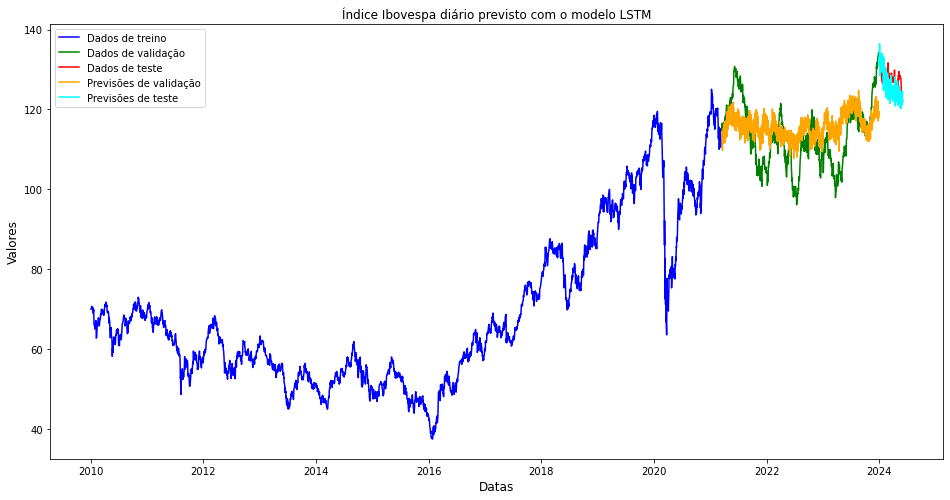

In [60]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino.index, treino['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')


# Linha das previsões
#plt.plot(prev_teste, label='Previsões testes', color='orange')
plt.plot(teste.index[2:],best_prediction,label='Previsões de validação',color = 'orange')
plt.plot(previsao.index,prediction_val,label='Previsões de teste',color = 'cyan')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo LSTM')

plt.legend()
plt.show()

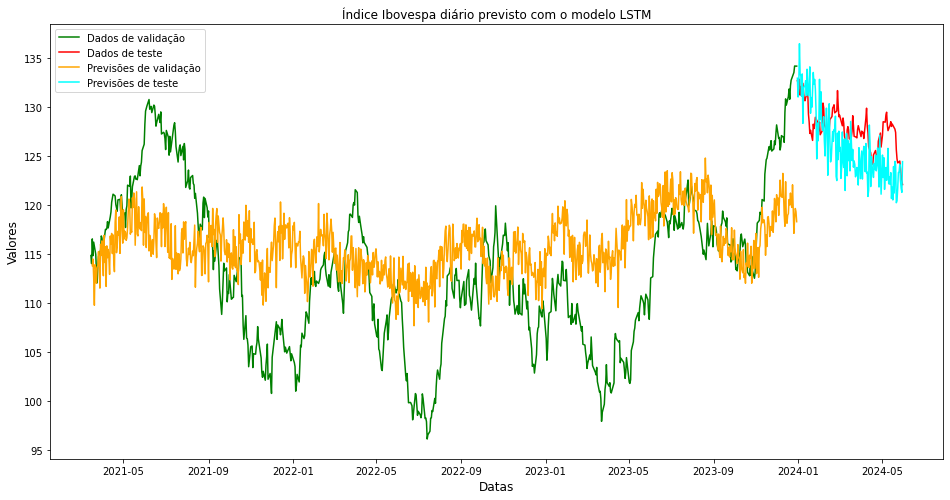

In [61]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino.index, treino['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')


# Linha das previsões
#plt.plot(prev_teste, label='Previsões testes', color='orange')
plt.plot(teste.index[2:],best_prediction,label='Previsões de validação',color = 'orange')
plt.plot(previsao.index,prediction_val,label='Previsões de teste',color = 'cyan')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo LSTM')

plt.legend()
plt.show()

# Eliminando dados irregulares da pandemia

In [13]:
treino1  = treino.loc['2016-01-01':'2020-02-01']
treino2 = treino.loc['2020-07-02':]
dados_pand = treino.loc['2020-02-02':'2020-07-01']

In [14]:
# Defina o intervalo de datas
data_inicio = '2020-02-02'
data_fim = '2020-07-01'

# Crie as datas dentro do intervalo
datas = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Gere valores entre 110 e 120
valores = np.linspace(117.597180, 96.234960, num=len(datas))

# Crie um DataFrame com as datas e valores
dados_pand = pd.DataFrame({'data': datas, 'valor': valores})
dados_pand.index = dados_pand['data']
dados_pand.drop('data', axis=1, inplace=True)


In [22]:
treino_sem_pand = pd.concat([treino1,dados_pand,treino2])
df_2 = pd.concat([treino_sem_pand, teste])
df_treino=pd.concat([treino_sem_pand])

In [23]:
entradas=10
x,y,train_x,train_y,test_x,test_y = escalonar(df_2,df_treino, entradas,scale)

In [24]:
from sklearn.model_selection import ParameterGrid
params_grid = {'num_layers':[2,5],
               'hid_size':[50,100],
              'lr': [0.01,0.02],
               'epochs':[400,600],
              'dropout_rate':[0.5,0.8]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

from sklearn.metrics import mean_squared_error, mean_absolute_error

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0

for p in grid:
    
    lstm = LSTM(in_dim = x.shape[-1],
                hid_dim = p['hid_size'],
                out_dim = x.shape[-1],
                num_layers = p['num_layers'], 
                dropout_rate= p['dropout_rate'])
    
    optimizer = torch.optim.Adam(lstm.parameters(), lr=p['lr'])
    
    loss_fun = nn.MSELoss()
    
    train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=p['epochs'])

    
    # testing the predction model on multiple time series
    last_x = train_x[-1].view(entradas)

    prediction_val = []

    while len(prediction_val)<len(test_y):
        prediction = lstm(last_x.view(1,entradas,1))
        prediction_val.append(prediction[0,0].item())


        ## replace the predicted value in last x
        last_x = torch.cat((last_x[1:],prediction[0]))

    # plot the result
    train_y_cp = scale.inverse_transform(train_y.detach().numpy())
    test_y_cp = scale.inverse_transform(test_y.detach().numpy())
    prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

    y_true = test_y_cp
    y_pred = prediction_val

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {RMSE}')

    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE: {MAE}')

    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'MAPE: {MAPE}%')
    
    print(f'parametros: {p}')
    
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = y_pred
        best_parameters = p
    
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

Total Possible Models 32
Epoch :0.0125    Train Loss :0.05370373651385307    Test Loss :0.1961299031972885
Epoch :0.025    Train Loss :0.0460972785949707    Test Loss :0.08777039498090744
Epoch :0.0375    Train Loss :0.04325943440198898    Test Loss :0.05154424533247948
Epoch :0.05    Train Loss :0.03273364156484604    Test Loss :0.07588961720466614
Epoch :0.0625    Train Loss :0.012512612156569958    Test Loss :0.004713875707238913
Epoch :0.075    Train Loss :0.01061689481139183    Test Loss :0.013297843746840954
Epoch :0.0875    Train Loss :0.0036364053376019    Test Loss :0.007087209261953831
Epoch :0.1    Train Loss :0.002764760982245207    Test Loss :0.008071561343967915
Epoch :0.1125    Train Loss :0.0021276604384183884    Test Loss :0.004954084288328886
Epoch :0.125    Train Loss :0.0017080450197681785    Test Loss :0.005689154379069805
Epoch :0.1375    Train Loss :0.0016897276509553194    Test Loss :0.004377251956611872
Epoch :0.15    Train Loss :0.0011549589689821005    Test L

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.08358918875455856    Test Loss :0.31573858857154846
Epoch :0.025    Train Loss :0.1060401052236557    Test Loss :0.2788003087043762
Epoch :0.0375    Train Loss :0.04932084307074547    Test Loss :0.06375124305486679
Epoch :0.05    Train Loss :0.05018046870827675    Test Loss :0.08979380130767822
Epoch :0.0625    Train Loss :0.04968831688165665    Test Loss :0.12137197703123093
Epoch :0.075    Train Loss :0.049285318702459335    Test Loss :0.1125001609325409
Epoch :0.0875    Train Loss :0.04858260229229927    Test Loss :0.09440267086029053
Epoch :0.1    Train Loss :0.04862048476934433    Test Loss :0.09188703447580338
Epoch :0.1125    Train Loss :0.048368487507104874    Test Loss :0.10141000151634216
Epoch :0.125    Train Loss :0.04840846359729767    Test Loss :0.10622398555278778
Epoch :0.1375    Train Loss :0.04794265329837799    Test Loss :0.09974738210439682
Epoch :0.15    Train Loss :0.04401277005672455    Test Loss :0.08482202142477036
Epoch :0.1625  

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  6.0
Epoch :0.0125    Train Loss :0.11265744268894196    Test Loss :0.37743985652923584
Epoch :0.025    Train Loss :0.09312788397073746    Test Loss :0.21490222215652466
Epoch :0.0375    Train Loss :0.0623285137116909    Test Loss :0.0470387302339077
Epoch :0.05    Train Loss :0.046575289219617844    Test Loss :0.1310250163078308
Epoch :0.0625    Train Loss :0.04383596032857895    Test Loss :0.10035494714975357
Epoch :0.075    Train Loss :0.035491056740283966    Test Loss :0.02522129751741886
Epoch :0.0875    Train Loss :0.008949121460318565    Test Loss :0.008869270794093609
Epoch :0.1    Train Loss :0.010225207544863224    Test Loss :0.010518158785998821
Epoch :0.1125    Train Loss :0.007030269131064415    Test Loss :0.03183085471391678
Epoch :0.125    Train Loss :0.0044680070132017136    Test Loss :0.012088312767446041
Epoch :0.1375    Train Loss :0.003077340079471469    Test Loss :0.0045195939019322395
Epoch :0.15    Train Loss :0.0018676109611988068    Test Loss :0.00411262

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.050877247005701065    Test Loss :0.01773151196539402
Epoch :0.025    Train Loss :0.06707604229450226    Test Loss :0.16353881359100342
Epoch :0.0375    Train Loss :0.051940422505140305    Test Loss :0.09063362330198288
Epoch :0.05    Train Loss :0.05056948959827423    Test Loss :0.1289021074771881
Epoch :0.0625    Train Loss :0.02767840586602688    Test Loss :0.06889357417821884
Epoch :0.075    Train Loss :0.013177239336073399    Test Loss :0.03043242171406746
Epoch :0.0875    Train Loss :0.015831826254725456    Test Loss :0.015688462182879448
Epoch :0.1    Train Loss :0.01079521980136633    Test Loss :0.0239519365131855
Epoch :0.1125    Train Loss :0.009459353983402252    Test Loss :0.026878271251916885
Epoch :0.125    Train Loss :0.006556317210197449    Test Loss :0.013157600536942482
Epoch :0.1375    Train Loss :0.00592959625646472    Test Loss :0.010029061697423458
Epoch :0.15    Train Loss :0.004806135315448046    Test Loss :0.011144374497234821
Epoc

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.13521212339401245    Test Loss :0.42198318243026733
Epoch :0.025    Train Loss :0.1255425661802292    Test Loss :0.29366180300712585
Epoch :0.0375    Train Loss :0.07379300892353058    Test Loss :0.029066964983940125
Epoch :0.05    Train Loss :0.04764110967516899    Test Loss :0.13830818235874176
Epoch :0.0625    Train Loss :0.027286693453788757    Test Loss :0.010527446866035461
Epoch :0.075    Train Loss :0.018299728631973267    Test Loss :0.04439498484134674
Epoch :0.0875    Train Loss :0.003934124950319529    Test Loss :0.009744009003043175
Epoch :0.1    Train Loss :0.0075135501101613045    Test Loss :0.006125406827777624
Epoch :0.1125    Train Loss :0.002338031306862831    Test Loss :0.003233277937397361
Epoch :0.125    Train Loss :0.0012939273146912456    Test Loss :0.007161331363022327
Epoch :0.1375    Train Loss :0.001797843025997281    Test Loss :0.002904744353145361
Epoch :0.15    Train Loss :0.0015716757625341415    Test Loss :0.007403242401778

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  16.0
Epoch :0.0125    Train Loss :0.05096137896180153    Test Loss :0.15021857619285583
Epoch :0.025    Train Loss :0.04913002997636795    Test Loss :0.10847171396017075
Epoch :0.0375    Train Loss :0.053244657814502716    Test Loss :0.0652020052075386
Epoch :0.05    Train Loss :0.045023731887340546    Test Loss :0.06830170005559921
Epoch :0.0625    Train Loss :0.02100411057472229    Test Loss :0.021506963297724724
Epoch :0.075    Train Loss :0.009690284729003906    Test Loss :0.01198344025760889
Epoch :0.0875    Train Loss :0.007310820743441582    Test Loss :0.011379534378647804
Epoch :0.1    Train Loss :0.005782108288258314    Test Loss :0.011650792323052883
Epoch :0.1125    Train Loss :0.004301217384636402    Test Loss :0.004803020041435957
Epoch :0.125    Train Loss :0.0025442165788263083    Test Loss :0.004692567512392998
Epoch :0.1375    Train Loss :0.0017737702000886202    Test Loss :0.002493191510438919
Epoch :0.15    Train Loss :0.0014516570372506976    Test Loss :0.00

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  19.0
Epoch :0.0125    Train Loss :0.3166038990020752    Test Loss :0.4980742037296295
Epoch :0.025    Train Loss :0.0315355621278286    Test Loss :0.2752096652984619
Epoch :0.0375    Train Loss :0.04589923471212387    Test Loss :0.02733299508690834
Epoch :0.05    Train Loss :0.0676436573266983    Test Loss :0.22830942273139954
Epoch :0.0625    Train Loss :0.04277336597442627    Test Loss :0.09384336322546005
Epoch :0.075    Train Loss :0.030584033578634262    Test Loss :0.06342477351427078
Epoch :0.0875    Train Loss :0.018600264564156532    Test Loss :0.029909947887063026
Epoch :0.1    Train Loss :0.004727923311293125    Test Loss :0.016731129959225655
Epoch :0.1125    Train Loss :0.006742662750184536    Test Loss :0.004023159854114056
Epoch :0.125    Train Loss :0.003107626922428608    Test Loss :0.004004651214927435
Epoch :0.1375    Train Loss :0.003865392180159688    Test Loss :0.008232817985117435
Epoch :0.15    Train Loss :0.0021547097712755203    Test Loss :0.00356681155

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.3108382821083069    Test Loss :3.0172595977783203
Epoch :0.025    Train Loss :0.0493953712284565    Test Loss :0.11682596057653427
Epoch :0.0375    Train Loss :0.049721360206604004    Test Loss :0.07853242754936218
Epoch :0.05    Train Loss :0.04934723675251007    Test Loss :0.1056285873055458
Epoch :0.0625    Train Loss :0.04863440617918968    Test Loss :0.11510826647281647
Epoch :0.075    Train Loss :0.04893966391682625    Test Loss :0.09336130321025848
Epoch :0.0875    Train Loss :0.04867119714617729    Test Loss :0.09731700271368027
Epoch :0.1    Train Loss :0.04856833070516586    Test Loss :0.10741887241601944
Epoch :0.1125    Train Loss :0.04855288565158844    Test Loss :0.09838074445724487
Epoch :0.125    Train Loss :0.048567552119493484    Test Loss :0.09848351031541824
Epoch :0.1375    Train Loss :0.04853712394833565    Test Loss :0.10448084771633148
Epoch :0.15    Train Loss :0.04859678074717522    Test Loss :0.0994722992181778
Epoch :0.1625    

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  25.0
Epoch :0.008333333333333333    Train Loss :0.04763152822852135    Test Loss :0.15449120104312897
Epoch :0.016666666666666666    Train Loss :0.039448440074920654    Test Loss :0.0273439884185791
Epoch :0.025    Train Loss :0.01523714791983366    Test Loss :0.005123323295265436
Epoch :0.03333333333333333    Train Loss :0.006189208477735519    Test Loss :0.03228064998984337
Epoch :0.041666666666666664    Train Loss :0.001991269877180457    Test Loss :0.005012789741158485
Epoch :0.05    Train Loss :0.003977368585765362    Test Loss :0.009577564895153046
Epoch :0.058333333333333334    Train Loss :0.0013566098641604185    Test Loss :0.0037085991352796555
Epoch :0.06666666666666667    Train Loss :0.0022493209689855576    Test Loss :0.002699288073927164
Epoch :0.075    Train Loss :0.0011834516189992428    Test Loss :0.002569870324805379
Epoch :0.08333333333333333    Train Loss :0.001302021904848516    Test Loss :0.0028549060225486755
Epoch :0.09166666666666666    Train Loss :0.001

Epoch :0.7333333333333333    Train Loss :0.000441130279796198    Test Loss :0.0007107287528924644
Epoch :0.7416666666666667    Train Loss :0.0003554769791662693    Test Loss :0.0006146759842522442
Epoch :0.75    Train Loss :0.00033275425084866583    Test Loss :0.0006089176167733967
Epoch :0.7583333333333333    Train Loss :0.0003203291562385857    Test Loss :0.0005803396925330162
Epoch :0.7666666666666667    Train Loss :0.0003175866149831563    Test Loss :0.0005827036802656949
Epoch :0.775    Train Loss :0.0003586531092878431    Test Loss :0.0006881210138089955
Epoch :0.7833333333333333    Train Loss :0.00031222065445035696    Test Loss :0.000620233709923923
Epoch :0.7916666666666666    Train Loss :0.00034900513128377497    Test Loss :0.0005753341247327626
Epoch :0.8    Train Loss :0.000307677430100739    Test Loss :0.0005781518411822617
Epoch :0.8083333333333333    Train Loss :0.0004054986929986626    Test Loss :0.0011149800848215818
Epoch :0.8166666666666667    Train Loss :0.002289572

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.07163774222135544    Test Loss :0.25775015354156494
Epoch :0.016666666666666666    Train Loss :0.05390153452754021    Test Loss :0.09843200445175171
Epoch :0.025    Train Loss :0.04951341822743416    Test Loss :0.08954264223575592
Epoch :0.03333333333333333    Train Loss :0.04939547926187515    Test Loss :0.12021739035844803
Epoch :0.041666666666666664    Train Loss :0.048210591077804565    Test Loss :0.10068386048078537
Epoch :0.05    Train Loss :0.046117741614580154    Test Loss :0.08069738000631332
Epoch :0.058333333333333334    Train Loss :0.02287921868264675    Test Loss :0.042106710374355316
Epoch :0.06666666666666667    Train Loss :0.015152519568800926    Test Loss :0.027614330872893333
Epoch :0.075    Train Loss :0.013486145064234734    Test Loss :0.03157248720526695
Epoch :0.08333333333333333    Train Loss :0.009451274760067463    Test Loss :0.008497217670083046
Epoch :0.09166666666666666    Train Loss :0.005901970434933901    Test 

Epoch :0.7416666666666667    Train Loss :0.0004807380901183933    Test Loss :0.0016069812700152397
Epoch :0.75    Train Loss :0.0004667051834985614    Test Loss :0.001692693680524826
Epoch :0.7583333333333333    Train Loss :0.0005719524924643338    Test Loss :0.0017381288344040513
Epoch :0.7666666666666667    Train Loss :0.0005219997838139534    Test Loss :0.0016448284732177854
Epoch :0.775    Train Loss :0.0004624825087375939    Test Loss :0.0016834783600643277
Epoch :0.7833333333333333    Train Loss :0.0004562059184536338    Test Loss :0.0016547010745853186
Epoch :0.7916666666666666    Train Loss :0.0004433905123732984    Test Loss :0.0015905173495411873
Epoch :0.8    Train Loss :0.0004635801597032696    Test Loss :0.0015482789603993297
Epoch :0.8083333333333333    Train Loss :0.0004351240932010114    Test Loss :0.0014719736063852906
Epoch :0.8166666666666667    Train Loss :0.0004707894695457071    Test Loss :0.0015852703945711255
Epoch :0.825    Train Loss :0.00041509713628329337   

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.05160736292600632    Test Loss :0.014187470078468323
Epoch :0.016666666666666666    Train Loss :0.033712562173604965    Test Loss :0.035968221724033356
Epoch :0.025    Train Loss :0.013507573865354061    Test Loss :0.014337798580527306
Epoch :0.03333333333333333    Train Loss :0.0023081356193870306    Test Loss :0.012575068511068821
Epoch :0.041666666666666664    Train Loss :0.002979850862175226    Test Loss :0.004318179562687874
Epoch :0.05    Train Loss :0.0028613614849746227    Test Loss :0.007183179259300232
Epoch :0.058333333333333334    Train Loss :0.001983135472983122    Test Loss :0.002436446724459529
Epoch :0.06666666666666667    Train Loss :0.0015355931827798486    Test Loss :0.002510074293240905
Epoch :0.075    Train Loss :0.0013950327411293983    Test Loss :0.0028618557844311
Epoch :0.08333333333333333    Train Loss :0.001102160313166678    Test Loss :0.0016466269735246897
Epoch :0.09166666666666666    Train Loss :0.0009042216697

Epoch :0.7333333333333333    Train Loss :0.0008812175365164876    Test Loss :0.0007935946341603994
Epoch :0.7416666666666667    Train Loss :0.00047779138549230993    Test Loss :0.0005282621132209897
Epoch :0.75    Train Loss :0.0002801150840241462    Test Loss :0.0007008156389929354
Epoch :0.7583333333333333    Train Loss :0.0002971100911963731    Test Loss :0.0005241486360318959
Epoch :0.7666666666666667    Train Loss :0.00032258377177640796    Test Loss :0.0005745419766753912
Epoch :0.775    Train Loss :0.0002758239861577749    Test Loss :0.0005166426417417824
Epoch :0.7833333333333333    Train Loss :0.0002665973734110594    Test Loss :0.0004827803059015423
Epoch :0.7916666666666666    Train Loss :0.00025160721270367503    Test Loss :0.0004568591248244047
Epoch :0.8    Train Loss :0.0002546774048823863    Test Loss :0.0004722759476862848
Epoch :0.8083333333333333    Train Loss :0.00022978401102591306    Test Loss :0.00044894294114783406
Epoch :0.8166666666666667    Train Loss :0.0002

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.09924039244651794    Test Loss :0.14948999881744385
Epoch :0.016666666666666666    Train Loss :0.04955904930830002    Test Loss :0.059460997581481934
Epoch :0.025    Train Loss :0.049776919186115265    Test Loss :0.13392028212547302
Epoch :0.03333333333333333    Train Loss :0.049152906984090805    Test Loss :0.09874845296144485
Epoch :0.041666666666666664    Train Loss :0.04979059845209122    Test Loss :0.08836822211742401
Epoch :0.05    Train Loss :0.04898505285382271    Test Loss :0.11696141958236694
Epoch :0.058333333333333334    Train Loss :0.04859520494937897    Test Loss :0.09577783197164536
Epoch :0.06666666666666667    Train Loss :0.04855481535196304    Test Loss :0.0972713902592659
Epoch :0.075    Train Loss :0.04062216356396675    Test Loss :0.09892846643924713
Epoch :0.08333333333333333    Train Loss :0.05089768022298813    Test Loss :0.08533088862895966
Epoch :0.09166666666666666    Train Loss :0.050216592848300934    Test Loss :

Epoch :0.7583333333333333    Train Loss :0.001164057059213519    Test Loss :0.0030005567241460085
Epoch :0.7666666666666667    Train Loss :0.0010928661795333028    Test Loss :0.002969886641949415
Epoch :0.775    Train Loss :0.0010033705038949847    Test Loss :0.002942072693258524
Epoch :0.7833333333333333    Train Loss :0.000994671368971467    Test Loss :0.0028836315032094717
Epoch :0.7916666666666666    Train Loss :0.0009881152072921395    Test Loss :0.0028317440301179886
Epoch :0.8    Train Loss :0.0009365796577185392    Test Loss :0.0028662527911365032
Epoch :0.8083333333333333    Train Loss :0.0010059010237455368    Test Loss :0.0029144417494535446
Epoch :0.8166666666666667    Train Loss :0.0009309897432103753    Test Loss :0.0027892214711755514
Epoch :0.825    Train Loss :0.0009004628518596292    Test Loss :0.0026427730917930603
Epoch :0.8333333333333334    Train Loss :0.000878480146639049    Test Loss :0.002792599145323038
Epoch :0.8416666666666667    Train Loss :0.00085972470697

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.14601053297519684    Test Loss :0.4607863426208496
Epoch :0.016666666666666666    Train Loss :0.1551525741815567    Test Loss :0.35768184065818787
Epoch :0.025    Train Loss :0.09117824584245682    Test Loss :0.025830555707216263
Epoch :0.03333333333333333    Train Loss :0.055828649550676346    Test Loss :0.17057229578495026
Epoch :0.041666666666666664    Train Loss :0.04118560254573822    Test Loss :0.07904820144176483
Epoch :0.05    Train Loss :0.03981684520840645    Test Loss :0.030542759224772453
Epoch :0.058333333333333334    Train Loss :0.026489894837141037    Test Loss :0.053814977407455444
Epoch :0.06666666666666667    Train Loss :0.008732819929718971    Test Loss :0.006863597314804792
Epoch :0.075    Train Loss :0.009781909175217152    Test Loss :0.013685821555554867
Epoch :0.08333333333333333    Train Loss :0.0026377320755273104    Test Loss :0.00575281074270606
Epoch :0.09166666666666666    Train Loss :0.003425109200179577    Test

Epoch :0.7333333333333333    Train Loss :0.00037865948979742825    Test Loss :0.0007123738178052008
Epoch :0.7416666666666667    Train Loss :0.0003797055978793651    Test Loss :0.0007638306706212461
Epoch :0.75    Train Loss :0.00039144844049587846    Test Loss :0.0007384430500678718
Epoch :0.7583333333333333    Train Loss :0.0004189048777334392    Test Loss :0.0008649219525977969
Epoch :0.7666666666666667    Train Loss :0.00041839852929115295    Test Loss :0.0009394341032020748
Epoch :0.775    Train Loss :0.00039459779509343207    Test Loss :0.0008107961039058864
Epoch :0.7833333333333333    Train Loss :0.00037832162342965603    Test Loss :0.0007198124076239765
Epoch :0.7916666666666666    Train Loss :0.0003703590773511678    Test Loss :0.0008187031489796937
Epoch :0.8    Train Loss :0.0003657825873233378    Test Loss :0.0007579867960885167
Epoch :0.8083333333333333    Train Loss :0.00036007133894599974    Test Loss :0.0006999146426096559
Epoch :0.8166666666666667    Train Loss :0.000

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.1520635038614273    Test Loss :0.5134586095809937
Epoch :0.016666666666666666    Train Loss :0.12605604529380798    Test Loss :0.11021926999092102
Epoch :0.025    Train Loss :0.0674864873290062    Test Loss :0.21903324127197266
Epoch :0.03333333333333333    Train Loss :0.053552594035863876    Test Loss :0.10988369584083557
Epoch :0.041666666666666664    Train Loss :0.05408082157373428    Test Loss :0.08223142474889755
Epoch :0.05    Train Loss :0.051529597491025925    Test Loss :0.13813552260398865
Epoch :0.058333333333333334    Train Loss :0.04929069057106972    Test Loss :0.09696003049612045
Epoch :0.06666666666666667    Train Loss :0.049829162657260895    Test Loss :0.08742158859968185
Epoch :0.075    Train Loss :0.04933801293373108    Test Loss :0.11477264016866684
Epoch :0.08333333333333333    Train Loss :0.04862377420067787    Test Loss :0.10403577238321304
Epoch :0.09166666666666666    Train Loss :0.04866144061088562    Test Loss :0.0

Epoch :0.7416666666666667    Train Loss :0.0005189463263377547    Test Loss :0.001909184269607067
Epoch :0.75    Train Loss :0.0005818168865516782    Test Loss :0.001999680418521166
Epoch :0.7583333333333333    Train Loss :0.0004929068381898105    Test Loss :0.0019388090586289763
Epoch :0.7666666666666667    Train Loss :0.0005110288038849831    Test Loss :0.0018532568356022239
Epoch :0.775    Train Loss :0.0005407049902714789    Test Loss :0.0019652273040264845
Epoch :0.7833333333333333    Train Loss :0.0005348941776901484    Test Loss :0.001889433478936553
Epoch :0.7916666666666666    Train Loss :0.00047957481001503766    Test Loss :0.0019266956951469183
Epoch :0.8    Train Loss :0.00048668571980670094    Test Loss :0.0018264141399413347
Epoch :0.8083333333333333    Train Loss :0.00047289481153711677    Test Loss :0.0018522392492741346
Epoch :0.8166666666666667    Train Loss :0.0004841394838877022    Test Loss :0.0019291319185867906
Epoch :0.825    Train Loss :0.0005134338862262666   

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.17302677035331726    Test Loss :0.15519703924655914
Epoch :0.016666666666666666    Train Loss :0.06765864044427872    Test Loss :0.1403142213821411
Epoch :0.025    Train Loss :0.043148934841156006    Test Loss :0.12496738135814667
Epoch :0.03333333333333333    Train Loss :0.043827302753925323    Test Loss :0.09789600223302841
Epoch :0.041666666666666664    Train Loss :0.029857762157917023    Test Loss :0.037000905722379684
Epoch :0.05    Train Loss :0.004591908771544695    Test Loss :0.0033470639027655125
Epoch :0.058333333333333334    Train Loss :0.030620167031884193    Test Loss :0.008360554464161396
Epoch :0.06666666666666667    Train Loss :0.01725601777434349    Test Loss :0.03723745793104172
Epoch :0.075    Train Loss :0.009051774628460407    Test Loss :0.018585531041026115
Epoch :0.08333333333333333    Train Loss :0.001934155123308301    Test Loss :0.009049219079315662
Epoch :0.09166666666666666    Train Loss :0.004697704687714577    T

Epoch :0.7333333333333333    Train Loss :0.0004617476661223918    Test Loss :0.0008496447699144483
Epoch :0.7416666666666667    Train Loss :0.0004479428753256798    Test Loss :0.0008775538299232721
Epoch :0.75    Train Loss :0.0004592086188495159    Test Loss :0.0008253277046605945
Epoch :0.7583333333333333    Train Loss :0.0004359058220870793    Test Loss :0.0008994448580779135
Epoch :0.7666666666666667    Train Loss :0.00044200202682986856    Test Loss :0.0008617141284048557
Epoch :0.775    Train Loss :0.00046801220742054284    Test Loss :0.0009194680606015027
Epoch :0.7833333333333333    Train Loss :0.00044287083437666297    Test Loss :0.0008121112477965653
Epoch :0.7916666666666666    Train Loss :0.00044916479964740574    Test Loss :0.0008383236709050834
Epoch :0.8    Train Loss :0.0004347632057033479    Test Loss :0.000823105510789901
Epoch :0.8083333333333333    Train Loss :0.00046224944526329637    Test Loss :0.0008439229568466544
Epoch :0.8166666666666667    Train Loss :0.00044

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.3430289626121521    Test Loss :0.23851047456264496
Epoch :0.016666666666666666    Train Loss :0.05963703617453575    Test Loss :0.0597258061170578
Epoch :0.025    Train Loss :0.048780471086502075    Test Loss :0.06812620162963867
Epoch :0.03333333333333333    Train Loss :0.050368793308734894    Test Loss :0.10077725350856781
Epoch :0.041666666666666664    Train Loss :0.04943588376045227    Test Loss :0.12457945197820663
Epoch :0.05    Train Loss :0.04907149821519852    Test Loss :0.10843831300735474
Epoch :0.058333333333333334    Train Loss :0.049077678471803665    Test Loss :0.09015067666769028
Epoch :0.06666666666666667    Train Loss :0.04848463460803032    Test Loss :0.09246854484081268
Epoch :0.075    Train Loss :0.0487963892519474    Test Loss :0.10355297476053238
Epoch :0.08333333333333333    Train Loss :0.048475757241249084    Test Loss :0.10733646154403687
Epoch :0.09166666666666666    Train Loss :0.048505302518606186    Test Loss :0

Epoch :0.7583333333333333    Train Loss :0.04849115386605263    Test Loss :0.10127457976341248
Epoch :0.7666666666666667    Train Loss :0.0485106036067009    Test Loss :0.10084419697523117
Epoch :0.775    Train Loss :0.048502273857593536    Test Loss :0.10079461336135864
Epoch :0.7833333333333333    Train Loss :0.0484669990837574    Test Loss :0.10116304457187653
Epoch :0.7916666666666666    Train Loss :0.048482805490493774    Test Loss :0.1003435030579567
Epoch :0.8    Train Loss :0.04847906157374382    Test Loss :0.1012304499745369
Epoch :0.8083333333333333    Train Loss :0.048490166664123535    Test Loss :0.10080645978450775
Epoch :0.8166666666666667    Train Loss :0.048490431159734726    Test Loss :0.10058026760816574
Epoch :0.825    Train Loss :0.04851289466023445    Test Loss :0.10102202743291855
Epoch :0.8333333333333334    Train Loss :0.04847685247659683    Test Loss :0.10092908143997192
Epoch :0.8416666666666667    Train Loss :0.048496101051568985    Test Loss :0.1006641238927

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  50.0
Epoch :0.0125    Train Loss :0.10953398793935776    Test Loss :0.05459243059158325
Epoch :0.025    Train Loss :0.0604017898440361    Test Loss :0.13700304925441742
Epoch :0.0375    Train Loss :0.04842020943760872    Test Loss :0.030561363324522972
Epoch :0.05    Train Loss :0.03253746032714844    Test Loss :0.08593744039535522
Epoch :0.0625    Train Loss :0.016133185476064682    Test Loss :0.015499788336455822
Epoch :0.075    Train Loss :0.0065040248446166515    Test Loss :0.018434688448905945
Epoch :0.0875    Train Loss :0.0050859590992331505    Test Loss :0.01736457645893097
Epoch :0.1    Train Loss :0.004176496062427759    Test Loss :0.005401658359915018
Epoch :0.1125    Train Loss :0.003150384407490492    Test Loss :0.004789759870618582
Epoch :0.125    Train Loss :0.0022255827207118273    Test Loss :0.007780366577208042
Epoch :0.1375    Train Loss :0.0019449911778792739    Test Loss :0.0034943914506584406
Epoch :0.15    Train Loss :0.0019953881856054068    Test Loss :0

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.058332640677690506    Test Loss :0.21874317526817322
Epoch :0.025    Train Loss :0.09098287671804428    Test Loss :0.2413407564163208
Epoch :0.0375    Train Loss :0.05163619667291641    Test Loss :0.0674523264169693
Epoch :0.05    Train Loss :0.05025581642985344    Test Loss :0.09695052355527878
Epoch :0.0625    Train Loss :0.05024091899394989    Test Loss :0.12623129785060883
Epoch :0.075    Train Loss :0.04864545911550522    Test Loss :0.10363124310970306
Epoch :0.0875    Train Loss :0.04852977767586708    Test Loss :0.08873730897903442
Epoch :0.1    Train Loss :0.045155201107263565    Test Loss :0.09194283932447433
Epoch :0.1125    Train Loss :0.021440668031573296    Test Loss :0.06224047392606735
Epoch :0.125    Train Loss :0.015453564003109932    Test Loss :0.02170160412788391
Epoch :0.1375    Train Loss :0.01237399596720934    Test Loss :0.013359946198761463
Epoch :0.15    Train Loss :0.008457924239337444    Test Loss :0.014485189691185951
Epoch :0.

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  56.00000000000001
Epoch :0.0125    Train Loss :0.11455292999744415    Test Loss :0.34626463055610657
Epoch :0.025    Train Loss :0.05862872302532196    Test Loss :0.08750545978546143
Epoch :0.0375    Train Loss :0.04649604484438896    Test Loss :0.12418433278799057
Epoch :0.05    Train Loss :0.046538565307855606    Test Loss :0.10726457834243774
Epoch :0.0625    Train Loss :0.03812083601951599    Test Loss :0.03331518918275833
Epoch :0.075    Train Loss :0.010112388990819454    Test Loss :0.03385275602340698
Epoch :0.0875    Train Loss :0.006249613128602505    Test Loss :0.01006506010890007
Epoch :0.1    Train Loss :0.006926975678652525    Test Loss :0.013105031102895737
Epoch :0.1125    Train Loss :0.004082071594893932    Test Loss :0.004719756543636322
Epoch :0.125    Train Loss :0.003196058562025428    Test Loss :0.011337385512888432
Epoch :0.1375    Train Loss :0.002235708525404334    Test Loss :0.005272580310702324
Epoch :0.15    Train Loss :0.0022732901852577925    Test L

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.08662417531013489    Test Loss :0.1683592051267624
Epoch :0.025    Train Loss :0.05091365799307823    Test Loss :0.06873864680528641
Epoch :0.0375    Train Loss :0.049518831074237823    Test Loss :0.12535469233989716
Epoch :0.05    Train Loss :0.04873783886432648    Test Loss :0.09379856288433075
Epoch :0.0625    Train Loss :0.048780299723148346    Test Loss :0.09649953246116638
Epoch :0.075    Train Loss :0.04886870086193085    Test Loss :0.11192073673009872
Epoch :0.0875    Train Loss :0.04867193102836609    Test Loss :0.0928882360458374
Epoch :0.1    Train Loss :0.04849213734269142    Test Loss :0.10423339158296585
Epoch :0.1125    Train Loss :0.04831496253609657    Test Loss :0.10210583359003067
Epoch :0.125    Train Loss :0.04486584663391113    Test Loss :0.09055058658123016
Epoch :0.1375    Train Loss :0.039460260421037674    Test Loss :0.035829879343509674
Epoch :0.15    Train Loss :0.025949733331799507    Test Loss :0.01373441144824028
Epoch :0.16

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.040886614471673965    Test Loss :0.024320023134350777
Epoch :0.025    Train Loss :0.0448511466383934    Test Loss :0.050150372087955475
Epoch :0.0375    Train Loss :0.010804690420627594    Test Loss :0.006050085183233023
Epoch :0.05    Train Loss :0.00808648206293583    Test Loss :0.041181329637765884
Epoch :0.0625    Train Loss :0.0034565224777907133    Test Loss :0.007074248977005482
Epoch :0.075    Train Loss :0.004426440689712763    Test Loss :0.02141895331442356
Epoch :0.0875    Train Loss :0.002749089850112796    Test Loss :0.004307764582335949
Epoch :0.1    Train Loss :0.002534377621486783    Test Loss :0.008275575935840607
Epoch :0.1125    Train Loss :0.002004264621064067    Test Loss :0.0034468299709260464
Epoch :0.125    Train Loss :0.0018384285503998399    Test Loss :0.004776321351528168
Epoch :0.1375    Train Loss :0.0016837985021993518    Test Loss :0.0026321574114263058
Epoch :0.15    Train Loss :0.001339281559921801    Test Loss :0.00255585

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.180807963013649    Test Loss :0.5014282464981079
Epoch :0.025    Train Loss :0.08281690627336502    Test Loss :0.04988905414938927
Epoch :0.0375    Train Loss :0.05611048638820648    Test Loss :0.14841328561306
Epoch :0.05    Train Loss :0.05210278183221817    Test Loss :0.07569336146116257
Epoch :0.0625    Train Loss :0.049061402678489685    Test Loss :0.125311940908432
Epoch :0.075    Train Loss :0.042381446808576584    Test Loss :0.08219006657600403
Epoch :0.0875    Train Loss :0.019901668652892113    Test Loss :0.016459884122014046
Epoch :0.1    Train Loss :0.012860221788287163    Test Loss :0.021028969436883926
Epoch :0.1125    Train Loss :0.008741021156311035    Test Loss :0.018225381150841713
Epoch :0.125    Train Loss :0.006355577148497105    Test Loss :0.016964493319392204
Epoch :0.1375    Train Loss :0.004271663725376129    Test Loss :0.007351642474532127
Epoch :0.15    Train Loss :0.0037560893688350916    Test Loss :0.005861189682036638
Epoch :

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.12813842296600342    Test Loss :0.13331547379493713
Epoch :0.025    Train Loss :0.06629647314548492    Test Loss :0.16468775272369385
Epoch :0.0375    Train Loss :0.04922444373369217    Test Loss :0.020358698442578316
Epoch :0.05    Train Loss :0.0320894829928875    Test Loss :0.0400630459189415
Epoch :0.0625    Train Loss :0.0175151526927948    Test Loss :0.017079530283808708
Epoch :0.075    Train Loss :0.007445767521858215    Test Loss :0.021016832441091537
Epoch :0.0875    Train Loss :0.00800548866391182    Test Loss :0.01982998475432396
Epoch :0.1    Train Loss :0.006822418887168169    Test Loss :0.011007986031472683
Epoch :0.1125    Train Loss :0.005384480580687523    Test Loss :0.010937131941318512
Epoch :0.125    Train Loss :0.004673491697758436    Test Loss :0.006027637980878353
Epoch :0.1375    Train Loss :0.004390430636703968    Test Loss :0.005454744212329388
Epoch :0.15    Train Loss :0.0032431266736239195    Test Loss :0.0074589126743376255
E

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.19234731793403625    Test Loss :0.2477770894765854
Epoch :0.025    Train Loss :0.08423370122909546    Test Loss :0.1843067854642868
Epoch :0.0375    Train Loss :0.04980728030204773    Test Loss :0.12563157081604004
Epoch :0.05    Train Loss :0.04878714680671692    Test Loss :0.08195038139820099
Epoch :0.0625    Train Loss :0.04920787736773491    Test Loss :0.11317528039216995
Epoch :0.075    Train Loss :0.04898177832365036    Test Loss :0.09766325354576111
Epoch :0.0875    Train Loss :0.04882746934890747    Test Loss :0.10003858059644699
Epoch :0.1    Train Loss :0.04878107085824013    Test Loss :0.10462556034326553
Epoch :0.1125    Train Loss :0.048972368240356445    Test Loss :0.09650028496980667
Epoch :0.125    Train Loss :0.04863027110695839    Test Loss :0.10494540631771088
Epoch :0.1375    Train Loss :0.04863453656435013    Test Loss :0.09730365127325058
Epoch :0.15    Train Loss :0.04864657297730446    Test Loss :0.10392893105745316
Epoch :0.1625  

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.04144841060042381    Test Loss :0.13824379444122314
Epoch :0.016666666666666666    Train Loss :0.03126468509435654    Test Loss :0.01089425664395094
Epoch :0.025    Train Loss :0.011404016055166721    Test Loss :0.020765172317624092
Epoch :0.03333333333333333    Train Loss :0.007639972493052483    Test Loss :0.011157965287566185
Epoch :0.041666666666666664    Train Loss :0.0052320160903036594    Test Loss :0.01802053116261959
Epoch :0.05    Train Loss :0.003091537393629551    Test Loss :0.004579393658787012
Epoch :0.058333333333333334    Train Loss :0.0021608455572277308    Test Loss :0.0071927690878510475
Epoch :0.06666666666666667    Train Loss :0.0020537725649774075    Test Loss :0.00589807378128171
Epoch :0.075    Train Loss :0.0019321038853377104    Test Loss :0.003033629385754466
Epoch :0.08333333333333333    Train Loss :0.001621514093130827    Test Loss :0.0030676687601953745
Epoch :0.09166666666666666    Train Loss :0.001398249412886

Epoch :0.7333333333333333    Train Loss :0.00046597281470894814    Test Loss :0.0007948854472488165
Epoch :0.7416666666666667    Train Loss :0.0004412841226439923    Test Loss :0.0007970110164023936
Epoch :0.75    Train Loss :0.00042722965008579195    Test Loss :0.0008645593770779669
Epoch :0.7583333333333333    Train Loss :0.00042215458233840764    Test Loss :0.0007834029383957386
Epoch :0.7666666666666667    Train Loss :0.0004178175877314061    Test Loss :0.0007449949625879526
Epoch :0.775    Train Loss :0.0005188838695175946    Test Loss :0.0008127131150104105
Epoch :0.7833333333333333    Train Loss :0.00039668037788942456    Test Loss :0.0009941038442775607
Epoch :0.7916666666666666    Train Loss :0.00043579406337812543    Test Loss :0.0007599809323437512
Epoch :0.8    Train Loss :0.0004406738153193146    Test Loss :0.000799013243522495
Epoch :0.8083333333333333    Train Loss :0.00044147964217700064    Test Loss :0.0009151166304945946
Epoch :0.8166666666666667    Train Loss :0.0005

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.05647261440753937    Test Loss :0.1531367301940918
Epoch :0.016666666666666666    Train Loss :0.05075876787304878    Test Loss :0.10519274324178696
Epoch :0.025    Train Loss :0.04900839179754257    Test Loss :0.09174536913633347
Epoch :0.03333333333333333    Train Loss :0.04539669677615166    Test Loss :0.09414790570735931
Epoch :0.041666666666666664    Train Loss :0.016066646203398705    Test Loss :0.016892658546566963
Epoch :0.05    Train Loss :0.01690470054745674    Test Loss :0.05941605195403099
Epoch :0.058333333333333334    Train Loss :0.010637249797582626    Test Loss :0.009180299006402493
Epoch :0.06666666666666667    Train Loss :0.008964949287474155    Test Loss :0.012258133850991726
Epoch :0.075    Train Loss :0.006537117995321751    Test Loss :0.013146523386240005
Epoch :0.08333333333333333    Train Loss :0.00485858554020524    Test Loss :0.0091688958927989
Epoch :0.09166666666666666    Train Loss :0.003591366345062852    Test Lo

Epoch :0.7416666666666667    Train Loss :0.0008357465849258006    Test Loss :0.002332958858460188
Epoch :0.75    Train Loss :0.0011579423444345593    Test Loss :0.002547754906117916
Epoch :0.7583333333333333    Train Loss :0.0007670972845517099    Test Loss :0.0027951509691774845
Epoch :0.7666666666666667    Train Loss :0.0008979723788797855    Test Loss :0.0023311374243348837
Epoch :0.775    Train Loss :0.000797886576037854    Test Loss :0.0023809263948351145
Epoch :0.7833333333333333    Train Loss :0.0007989124278537929    Test Loss :0.0023228321224451065
Epoch :0.7916666666666666    Train Loss :0.0007174939382821321    Test Loss :0.002394889248535037
Epoch :0.8    Train Loss :0.0008288547396659851    Test Loss :0.002341478830203414
Epoch :0.8083333333333333    Train Loss :0.0007060000789351761    Test Loss :0.002222116570919752
Epoch :0.8166666666666667    Train Loss :0.0007406451040878892    Test Loss :0.0022752985823899508
Epoch :0.825    Train Loss :0.0007271392387337983    Test 

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.14440444111824036    Test Loss :0.45755234360694885
Epoch :0.016666666666666666    Train Loss :0.10667448490858078    Test Loss :0.22809749841690063
Epoch :0.025    Train Loss :0.06915145367383957    Test Loss :0.03873388469219208
Epoch :0.03333333333333333    Train Loss :0.04874277114868164    Test Loss :0.14527760446071625
Epoch :0.041666666666666664    Train Loss :0.04294094443321228    Test Loss :0.09535673260688782
Epoch :0.05    Train Loss :0.03633886203169823    Test Loss :0.02255847491323948
Epoch :0.058333333333333334    Train Loss :0.01686261035501957    Test Loss :0.023704906925559044
Epoch :0.06666666666666667    Train Loss :0.012719415128231049    Test Loss :0.021441275253891945
Epoch :0.075    Train Loss :0.006513870321214199    Test Loss :0.024670984596014023
Epoch :0.08333333333333333    Train Loss :0.005619911011308432    Test Loss :0.0167501512914896
Epoch :0.09166666666666666    Train Loss :0.004242573399096727    Test Los

Epoch :0.7416666666666667    Train Loss :0.000463348173070699    Test Loss :0.0009675471228547394
Epoch :0.75    Train Loss :0.0005678373272530735    Test Loss :0.0011930257314816117
Epoch :0.7583333333333333    Train Loss :0.0010047369869425893    Test Loss :0.0014225962804630399
Epoch :0.7666666666666667    Train Loss :0.0005778386839665473    Test Loss :0.001081752823665738
Epoch :0.775    Train Loss :0.0006134492577984929    Test Loss :0.0012122727930545807
Epoch :0.7833333333333333    Train Loss :0.0005088098114356399    Test Loss :0.0012446475448086858
Epoch :0.7916666666666666    Train Loss :0.0005211755051277578    Test Loss :0.001096776220947504
Epoch :0.8    Train Loss :0.0005082920542918146    Test Loss :0.001004389370791614
Epoch :0.8083333333333333    Train Loss :0.0004743348399642855    Test Loss :0.0010481708450242877
Epoch :0.8166666666666667    Train Loss :0.00046845077304169536    Test Loss :0.0010386084904894233
Epoch :0.825    Train Loss :0.00048497685929760337    T

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.12940028309822083    Test Loss :0.37688761949539185
Epoch :0.016666666666666666    Train Loss :0.05832389369606972    Test Loss :0.06372640281915665
Epoch :0.025    Train Loss :0.05265545845031738    Test Loss :0.12424720823764801
Epoch :0.03333333333333333    Train Loss :0.05035295709967613    Test Loss :0.09541255980730057
Epoch :0.041666666666666664    Train Loss :0.04998864606022835    Test Loss :0.1109885647892952
Epoch :0.05    Train Loss :0.04920370504260063    Test Loss :0.09263088554143906
Epoch :0.058333333333333334    Train Loss :0.04894792661070824    Test Loss :0.11057883501052856
Epoch :0.06666666666666667    Train Loss :0.0489286445081234    Test Loss :0.09320944547653198
Epoch :0.075    Train Loss :0.04862011596560478    Test Loss :0.10694769769906998
Epoch :0.08333333333333333    Train Loss :0.0485825277864933    Test Loss :0.09757077693939209
Epoch :0.09166666666666666    Train Loss :0.048609159886837006    Test Loss :0.102

Epoch :0.75    Train Loss :0.001179891056381166    Test Loss :0.0029990095645189285
Epoch :0.7583333333333333    Train Loss :0.001120646484196186    Test Loss :0.0029228206258267164
Epoch :0.7666666666666667    Train Loss :0.00096441141795367    Test Loss :0.0026277152355760336
Epoch :0.775    Train Loss :0.0009742479887790978    Test Loss :0.002664581872522831
Epoch :0.7833333333333333    Train Loss :0.0010695317760109901    Test Loss :0.0026394976302981377
Epoch :0.7916666666666666    Train Loss :0.001013545086607337    Test Loss :0.002697613788768649
Epoch :0.8    Train Loss :0.0009655660251155496    Test Loss :0.0026128911413252354
Epoch :0.8083333333333333    Train Loss :0.0009843085426837206    Test Loss :0.002462639007717371
Epoch :0.8166666666666667    Train Loss :0.0009572517010383308    Test Loss :0.0026192122604697943
Epoch :0.825    Train Loss :0.0012279106304049492    Test Loss :0.0030166199430823326
Epoch :0.8333333333333334    Train Loss :0.001816300442442298    Test Los

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.14204715192317963    Test Loss :0.44249966740608215
Epoch :0.016666666666666666    Train Loss :0.12260749936103821    Test Loss :0.26218947768211365
Epoch :0.025    Train Loss :0.05182987079024315    Test Loss :0.09764490276575089
Epoch :0.03333333333333333    Train Loss :0.05286436527967453    Test Loss :0.13510540127754211
Epoch :0.041666666666666664    Train Loss :0.03782486915588379    Test Loss :0.01568763144314289
Epoch :0.05    Train Loss :0.021967772394418716    Test Loss :0.03883020579814911
Epoch :0.058333333333333334    Train Loss :0.00831400416791439    Test Loss :0.01554033998399973
Epoch :0.06666666666666667    Train Loss :0.004897816106677055    Test Loss :0.0065955109894275665
Epoch :0.075    Train Loss :0.003100055269896984    Test Loss :0.0071390047669410706
Epoch :0.08333333333333333    Train Loss :0.0022932521533221006    Test Loss :0.007971266284584999
Epoch :0.09166666666666666    Train Loss :0.002539808163419366    Tes

Epoch :0.7333333333333333    Train Loss :0.000445233570644632    Test Loss :0.0008399498765356839
Epoch :0.7416666666666667    Train Loss :0.0004822389455512166    Test Loss :0.0008910520700737834
Epoch :0.75    Train Loss :0.00048657003208063543    Test Loss :0.0008490571635775268
Epoch :0.7583333333333333    Train Loss :0.00046308033051900566    Test Loss :0.0008839676156640053
Epoch :0.7666666666666667    Train Loss :0.0004450116539373994    Test Loss :0.0008197784190997481
Epoch :0.775    Train Loss :0.00044447247637435794    Test Loss :0.00079684256343171
Epoch :0.7833333333333333    Train Loss :0.00044989705202169716    Test Loss :0.0009484942420385778
Epoch :0.7916666666666666    Train Loss :0.00042492453940212727    Test Loss :0.0008121263817884028
Epoch :0.8    Train Loss :0.00045431952457875013    Test Loss :0.0008380190120078623
Epoch :0.8083333333333333    Train Loss :0.0004558711952995509    Test Loss :0.0008634150726720691
Epoch :0.8166666666666667    Train Loss :0.000463

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.11349872499704361    Test Loss :0.34953707456588745
Epoch :0.016666666666666666    Train Loss :0.05717635154724121    Test Loss :0.03108051046729088
Epoch :0.025    Train Loss :0.058807212859392166    Test Loss :0.16489256918430328
Epoch :0.03333333333333333    Train Loss :0.05141327157616615    Test Loss :0.06901425868272781
Epoch :0.041666666666666664    Train Loss :0.048828814178705215    Test Loss :0.11984466761350632
Epoch :0.05    Train Loss :0.049982450902462006    Test Loss :0.11271107196807861
Epoch :0.058333333333333334    Train Loss :0.049067262560129166    Test Loss :0.08483031392097473
Epoch :0.06666666666666667    Train Loss :0.048163626343011856    Test Loss :0.10854648053646088
Epoch :0.075    Train Loss :0.04365690052509308    Test Loss :0.10063787549734116
Epoch :0.08333333333333333    Train Loss :0.021184850484132767    Test Loss :0.01633703149855137
Epoch :0.09166666666666666    Train Loss :0.01076622772961855    Test Los

Epoch :0.7416666666666667    Train Loss :0.0006563684437423944    Test Loss :0.00197025528177619
Epoch :0.75    Train Loss :0.0006167844985611737    Test Loss :0.002136701252311468
Epoch :0.7583333333333333    Train Loss :0.0006028427742421627    Test Loss :0.0018533548573032022
Epoch :0.7666666666666667    Train Loss :0.0006118676392361522    Test Loss :0.0018826043233275414
Epoch :0.775    Train Loss :0.0007951473817229271    Test Loss :0.0020774651784449816
Epoch :0.7833333333333333    Train Loss :0.0005601562443189323    Test Loss :0.00202458375133574
Epoch :0.7916666666666666    Train Loss :0.0006149075925350189    Test Loss :0.0018333011539652944
Epoch :0.8    Train Loss :0.0006054590921849012    Test Loss :0.001800764468498528
Epoch :0.8083333333333333    Train Loss :0.0006758804083801806    Test Loss :0.0020205664914101362
Epoch :0.8166666666666667    Train Loss :0.0006303902482613921    Test Loss :0.0020190891809761524
Epoch :0.825    Train Loss :0.0005838857614435256    Test 

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.1618167757987976    Test Loss :0.23848986625671387
Epoch :0.016666666666666666    Train Loss :0.03657921031117439    Test Loss :0.026832249015569687
Epoch :0.025    Train Loss :0.05820627883076668    Test Loss :0.1433085799217224
Epoch :0.03333333333333333    Train Loss :0.027450306341052055    Test Loss :0.09487105906009674
Epoch :0.041666666666666664    Train Loss :0.017042679712176323    Test Loss :0.0065146926790475845
Epoch :0.05    Train Loss :0.014004991389811039    Test Loss :0.008727083913981915
Epoch :0.058333333333333334    Train Loss :0.006364470347762108    Test Loss :0.007563790772110224
Epoch :0.06666666666666667    Train Loss :0.00585974520072341    Test Loss :0.016489049419760704
Epoch :0.075    Train Loss :0.003355202730745077    Test Loss :0.006395549979060888
Epoch :0.08333333333333333    Train Loss :0.002794605912640691    Test Loss :0.004854491446167231
Epoch :0.09166666666666666    Train Loss :0.002422071062028408    T

Epoch :0.7416666666666667    Train Loss :0.0004733038367703557    Test Loss :0.0019762858282774687
Epoch :0.75    Train Loss :0.00045683913049288094    Test Loss :0.002016014652326703
Epoch :0.7583333333333333    Train Loss :0.00046088811359368265    Test Loss :0.0019183788681402802
Epoch :0.7666666666666667    Train Loss :0.0004757912829518318    Test Loss :0.001985808601602912
Epoch :0.775    Train Loss :0.00048066984163597226    Test Loss :0.0019123191013932228
Epoch :0.7833333333333333    Train Loss :0.00045292291906662285    Test Loss :0.0019207042641937733
Epoch :0.7916666666666666    Train Loss :0.00046230500447563827    Test Loss :0.001958004431799054
Epoch :0.8    Train Loss :0.00043816445395350456    Test Loss :0.0018782520201057196
Epoch :0.8083333333333333    Train Loss :0.0004436403978615999    Test Loss :0.001933528110384941
Epoch :0.8166666666666667    Train Loss :0.00044142716797068715    Test Loss :0.0020538303069770336
Epoch :0.825    Train Loss :0.0004553266626317054

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.23485684394836426    Test Loss :0.38218000531196594
Epoch :0.016666666666666666    Train Loss :0.10009186714887619    Test Loss :0.10463397949934006
Epoch :0.025    Train Loss :0.05090665444731712    Test Loss :0.08748102933168411
Epoch :0.03333333333333333    Train Loss :0.04963137209415436    Test Loss :0.08399683982133865
Epoch :0.041666666666666664    Train Loss :0.049246858805418015    Test Loss :0.08430825918912888
Epoch :0.05    Train Loss :0.04941480606794357    Test Loss :0.09288562834262848
Epoch :0.058333333333333334    Train Loss :0.049190931022167206    Test Loss :0.10058752447366714
Epoch :0.06666666666666667    Train Loss :0.04876074194908142    Test Loss :0.1074429601430893
Epoch :0.075    Train Loss :0.04886538162827492    Test Loss :0.10846653580665588
Epoch :0.08333333333333333    Train Loss :0.049036018550395966    Test Loss :0.10643868148326874
Epoch :0.09166666666666666    Train Loss :0.048884522169828415    Test Loss :

Epoch :0.7583333333333333    Train Loss :0.04850418120622635    Test Loss :0.10107920318841934
Epoch :0.7666666666666667    Train Loss :0.04850107431411743    Test Loss :0.10100651532411575
Epoch :0.775    Train Loss :0.04848600924015045    Test Loss :0.10104554146528244
Epoch :0.7833333333333333    Train Loss :0.04847041517496109    Test Loss :0.10104502737522125
Epoch :0.7916666666666666    Train Loss :0.04847126081585884    Test Loss :0.1009392961859703
Epoch :0.8    Train Loss :0.0485355481505394    Test Loss :0.1011568233370781
Epoch :0.8083333333333333    Train Loss :0.04851344972848892    Test Loss :0.10107851773500443
Epoch :0.8166666666666667    Train Loss :0.048505183309316635    Test Loss :0.10103785246610641
Epoch :0.825    Train Loss :0.048522256314754486    Test Loss :0.10086710005998611
Epoch :0.8333333333333334    Train Loss :0.04851362109184265    Test Loss :0.10079850256443024
Epoch :0.8416666666666667    Train Loss :0.04851800575852394    Test Loss :0.100840218365192

C:\Users\alex\AppData\Local\Temp\ipykernel_24736\1534276625.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':best_rmse,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [28]:
print(parameters.loc[0, 'Parameters'])

{'dropout_rate': 0.5, 'epochs': 600, 'hid_size': 100, 'lr': 0.02, 'num_layers': 5}


In [33]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 7.5447396802609825
MAE: 6.102888206518667
MAPE: 5.2996307363628805
{'dropout_rate': 0.5, 'epochs': 600, 'hid_size': 100, 'lr': 0.01, 'num_layers': 2}


In [34]:
best_parameters

{'dropout_rate': 0.5,
 'epochs': 600,
 'hid_size': 100,
 'lr': 0.01,
 'num_layers': 2}

In [40]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 7.5447396802609825
MAE: 6.102888206518667
MAPE: 5.2996307363628805
{'dropout_rate': 0.5, 'epochs': 600, 'hid_size': 100, 'lr': 0.01, 'num_layers': 2}


In [26]:
treino_sem_pand = pd.concat([treino1,dados_pand,treino2])
df_3 = pd.concat([treino_sem_pand, teste,previsao])
df_treino=pd.concat([treino_sem_pand, teste])
df_teste=pd.concat([previsao])

In [27]:
x,y,train_x,train_y,test_x,test_y = escalonar(df_3,df_treino, 10,scale)

In [35]:
   
lstm = LSTM(in_dim = x.shape[-1],
            hid_dim = best_parameters['hid_size'],
            out_dim = x.shape[-1],
            num_layers =best_parameters['num_layers'], 
            dropout_rate= best_parameters['dropout_rate'])

optimizer = torch.optim.Adam(lstm.parameters(), lr=best_parameters['lr'])

loss_fun = nn.MSELoss()

train_loss, test_loss = train_model(lstm,
           loss_fun,
           optimizer,
           train_x,
           test_x,
           train_y,
           test_y,
           epochs=best_parameters['epochs'])


# testing the predction model on multiple time series
last_x = train_x[-1].view(entradas)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,entradas,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
train_y_cp = scale.inverse_transform(train_y.detach().numpy())
test_y_cp = scale.inverse_transform(test_y.detach().numpy())
prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

y_true = test_y_cp
y_pred = prediction_val

RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {RMSE}')

MAE = mean_absolute_error(y_true, y_pred)
print(f'MAE: {MAE}')

MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {MAPE}%')

print(best_parameters)


Epoch :0.008333333333333333    Train Loss :0.19196633994579315    Test Loss :0.6434115171432495
Epoch :0.016666666666666666    Train Loss :0.22940929234027863    Test Loss :0.5244870185852051
Epoch :0.025    Train Loss :0.04880211874842644    Test Loss :0.005766528192907572
Epoch :0.03333333333333333    Train Loss :0.04859005659818649    Test Loss :0.1744924783706665
Epoch :0.041666666666666664    Train Loss :0.05619261786341667    Test Loss :0.15882572531700134
Epoch :0.05    Train Loss :0.03949602693319321    Test Loss :0.036220721900463104
Epoch :0.058333333333333334    Train Loss :0.029261261224746704    Test Loss :0.045265186578035355
Epoch :0.06666666666666667    Train Loss :0.012155870907008648    Test Loss :0.009979651309549809
Epoch :0.075    Train Loss :0.010197202675044537    Test Loss :0.009823513217270374
Epoch :0.08333333333333333    Train Loss :0.005420383531600237    Test Loss :0.01135500892996788
Epoch :0.09166666666666666    Train Loss :0.0037008689250797033    Test L

Epoch :0.7416666666666667    Train Loss :0.00047301160520873964    Test Loss :0.0005528192268684506
Epoch :0.75    Train Loss :0.00046568294055759907    Test Loss :0.00048504327423870564
Epoch :0.7583333333333333    Train Loss :0.0004647833702620119    Test Loss :0.0003903301840182394
Epoch :0.7666666666666667    Train Loss :0.000491270562633872    Test Loss :0.0005062040290795267
Epoch :0.775    Train Loss :0.000455072324257344    Test Loss :0.0005341749056242406
Epoch :0.7833333333333333    Train Loss :0.00045957902329973876    Test Loss :0.0004531491722445935
Epoch :0.7916666666666666    Train Loss :0.000453455577371642    Test Loss :0.0003698829677887261
Epoch :0.8    Train Loss :0.00046409512287937105    Test Loss :0.0004843389324378222
Epoch :0.8083333333333333    Train Loss :0.0004351520328782499    Test Loss :0.00035451888106763363
Epoch :0.8166666666666667    Train Loss :0.0004625805886462331    Test Loss :0.0004699612036347389
Epoch :0.825    Train Loss :0.0004383387567941099

In [192]:
len(treino_sem_pand)

1900

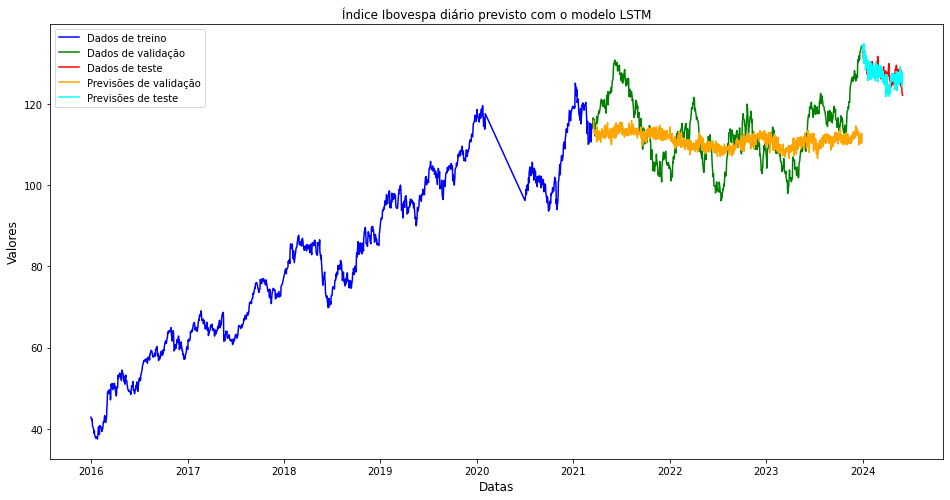

In [39]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')


# Linha das previsões
#plt.plot(prev_teste, label='Previsões testes', color='orange')
plt.plot(teste.index[3:],best_prediction,label='Previsões de validação',color = 'orange')
plt.plot(previsao.index,prediction_val,label='Previsões de teste',color = 'cyan')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo LSTM')

plt.legend()
plt.show()

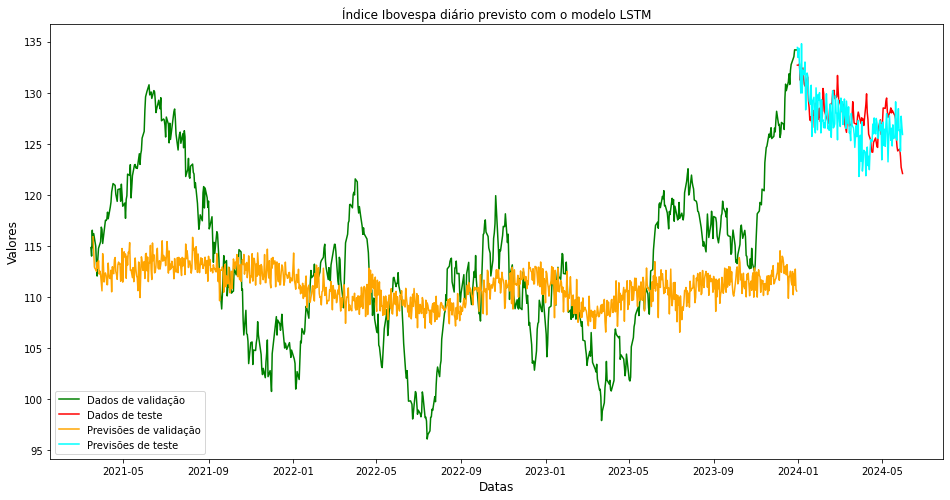

In [38]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')


# Linha das previsões
#plt.plot(prev_teste, label='Previsões testes', color='orange')
plt.plot(teste.index[3:],best_prediction,label='Previsões de validação',color = 'orange')
plt.plot(previsao.index,prediction_val,label='Previsões de teste',color = 'cyan')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo LSTM')

plt.legend()
plt.show()

# Série com dados mensais

In [13]:
treino_mensal = treino.copy()
teste_mensal = teste.copy()
previsao_mensal = previsao.copy()

In [14]:
treino_mensal = treino_mensal['valor'].resample('M').mean()
teste_mensal = teste_mensal['valor'].resample('M').mean()
previsao_mensal = previsao_mensal['valor'].resample('M').mean()
data = treino_mensal.to_frame()

In [15]:
treino_mensal = treino_mensal.to_frame(name='valor')
teste_mensal = teste_mensal.to_frame(name='valor')
previsao_mensal = previsao_mensal.to_frame(name='valor')

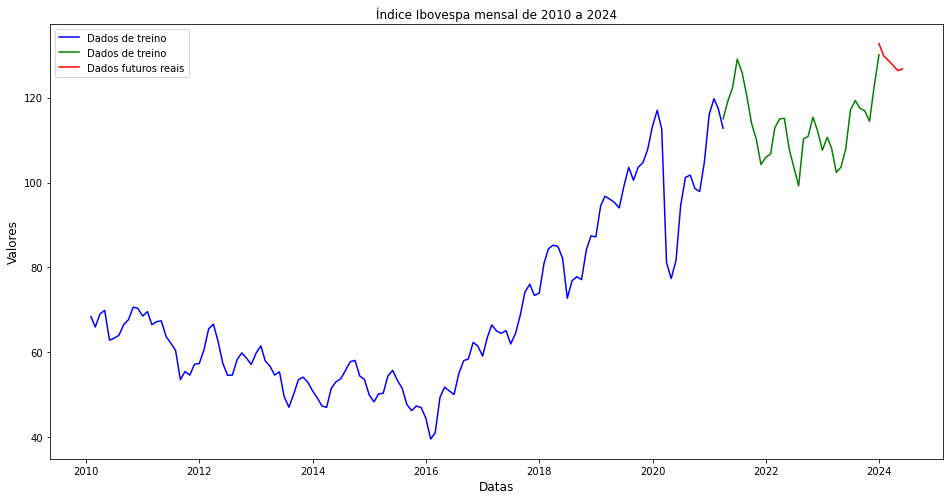

In [16]:


#suavizado = pd.concat([treino_mensal,teste_mensal, previsao_mensal])
##Monthly Stock Price 
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_mensal,color='blue', label='Dados de treino')
plt.plot(teste_mensal,color='green', label='Dados de treino')
plt.plot(previsao_mensal,color='red', label='Dados futuros reais')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal de 2010 a 2024')

plt.legend()
plt.show()

In [17]:
df_4 = pd.concat([treino_mensal, teste_mensal])
df_treino = treino_mensal
df_teste=pd.concat([teste_mensal])

In [18]:
entradas = 10
x,y,train_x,train_y,test_x,test_y = escalonar(df_4,df_treino, entradas,scale)

In [19]:
from sklearn.model_selection import ParameterGrid
params_grid = {'num_layers':[2,5],
               'hid_size':[50,100],
              'lr': [0.01,0.02],
               'epochs':[400,600],
              'dropout_rate':[0.5,0.8]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

from sklearn.metrics import mean_squared_error, mean_absolute_error

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0

for p in grid:
    
    lstm = LSTM(in_dim = x.shape[-1],
                hid_dim = p['hid_size'],
                out_dim = x.shape[-1],
                num_layers = p['num_layers'], 
                dropout_rate= p['dropout_rate'])
    
    optimizer = torch.optim.Adam(lstm.parameters(), lr=p['lr'])
    
    loss_fun = nn.MSELoss()
    
    train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=p['epochs'])

    
    # testing the predction model on multiple time series
    last_x = train_x[-1].view(entradas)

    prediction_val = []

    while len(prediction_val)<len(test_y):
        prediction = lstm(last_x.view(1,entradas,1))
        prediction_val.append(prediction[0,0].item())


        ## replace the predicted value in last x
        last_x = torch.cat((last_x[1:],prediction[0]))

    # plot the result
    train_y_cp = scale.inverse_transform(train_y.detach().numpy())
    test_y_cp = scale.inverse_transform(test_y.detach().numpy())
    prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

    y_true = test_y_cp
    y_pred = prediction_val

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {RMSE}')

    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE: {MAE}')

    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'MAPE: {MAPE}%')
    
    print(f'parametros: {p}')
    
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction2 = y_pred
        best_parameters2 = p
    
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

Total Possible Models 32
Epoch :0.0125    Train Loss :0.049272578209638596    Test Loss :0.29468730092048645
Epoch :0.025    Train Loss :0.037441957741975784    Test Loss :0.04357845336198807
Epoch :0.0375    Train Loss :0.011504072695970535    Test Loss :0.1682353913784027
Epoch :0.05    Train Loss :0.009648674167692661    Test Loss :0.039908722043037415
Epoch :0.0625    Train Loss :0.012942342087626457    Test Loss :0.025103731080889702
Epoch :0.075    Train Loss :0.007076506968587637    Test Loss :0.00905718095600605
Epoch :0.0875    Train Loss :0.008262863382697105    Test Loss :0.018650725483894348
Epoch :0.1    Train Loss :0.007383127696812153    Test Loss :0.011340005323290825
Epoch :0.1125    Train Loss :0.006640708073973656    Test Loss :0.008802102878689766
Epoch :0.125    Train Loss :0.006118675693869591    Test Loss :0.006537407636642456
Epoch :0.1375    Train Loss :0.0056923371739685535    Test Loss :0.010568438097834587
Epoch :0.15    Train Loss :0.005752131808549166    T

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  3.0
Epoch :0.0125    Train Loss :0.05252869054675102    Test Loss :0.2209799587726593
Epoch :0.025    Train Loss :0.047091808170080185    Test Loss :0.15601998567581177
Epoch :0.0375    Train Loss :0.02079875022172928    Test Loss :0.19269713759422302
Epoch :0.05    Train Loss :0.05223977938294411    Test Loss :0.23288923501968384
Epoch :0.0625    Train Loss :0.05081142485141754    Test Loss :0.21188227832317352
Epoch :0.075    Train Loss :0.04537808522582054    Test Loss :0.1970781832933426
Epoch :0.0875    Train Loss :0.019251372665166855    Test Loss :0.014423621818423271
Epoch :0.1    Train Loss :0.012287328019738197    Test Loss :0.025415560230612755
Epoch :0.1125    Train Loss :0.013186728581786156    Test Loss :0.03361731395125389
Epoch :0.125    Train Loss :0.01195800956338644    Test Loss :0.013557526282966137
Epoch :0.1375    Train Loss :0.010947590693831444    Test Loss :0.03726170212030411
Epoch :0.15    Train Loss :0.01026776060461998    Test Loss :0.02298694290220

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  6.0
Epoch :0.0125    Train Loss :0.14550837874412537    Test Loss :0.5982699394226074
Epoch :0.025    Train Loss :0.050177451223134995    Test Loss :0.06795663386583328
Epoch :0.0375    Train Loss :0.051274944096803665    Test Loss :0.27907896041870117
Epoch :0.05    Train Loss :0.03709125146269798    Test Loss :0.10291661322116852
Epoch :0.0625    Train Loss :0.02173190377652645    Test Loss :0.018410226330161095
Epoch :0.075    Train Loss :0.01715245097875595    Test Loss :0.058865949511528015
Epoch :0.0875    Train Loss :0.008491179905831814    Test Loss :0.03699735552072525
Epoch :0.1    Train Loss :0.007969362661242485    Test Loss :0.023465055972337723
Epoch :0.1125    Train Loss :0.009166006930172443    Test Loss :0.009443196468055248
Epoch :0.125    Train Loss :0.007179598789662123    Test Loss :0.010133396834135056
Epoch :0.1375    Train Loss :0.007193929515779018    Test Loss :0.02104339934885502
Epoch :0.15    Train Loss :0.006269006058573723    Test Loss :0.00766075

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.08694431930780411    Test Loss :0.291814923286438
Epoch :0.025    Train Loss :0.05117888003587723    Test Loss :0.20724725723266602
Epoch :0.0375    Train Loss :0.05061361938714981    Test Loss :0.23800219595432281
Epoch :0.05    Train Loss :0.03231842815876007    Test Loss :0.050187453627586365
Epoch :0.0625    Train Loss :0.040867142379283905    Test Loss :0.14193189144134521
Epoch :0.075    Train Loss :0.021859465166926384    Test Loss :0.07741601765155792
Epoch :0.0875    Train Loss :0.015985757112503052    Test Loss :0.027552582323551178
Epoch :0.1    Train Loss :0.012410465627908707    Test Loss :0.022361449897289276
Epoch :0.1125    Train Loss :0.011085798032581806    Test Loss :0.022406404837965965
Epoch :0.125    Train Loss :0.013535945676267147    Test Loss :0.024794569239020348
Epoch :0.1375    Train Loss :0.009545672684907913    Test Loss :0.028108106926083565
Epoch :0.15    Train Loss :0.01002983283251524    Test Loss :0.021610643714666367
Ep

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.11893653869628906    Test Loss :0.5956514477729797
Epoch :0.025    Train Loss :0.09293831884860992    Test Loss :0.35971903800964355
Epoch :0.0375    Train Loss :0.04291010648012161    Test Loss :0.20381580293178558
Epoch :0.05    Train Loss :0.043086376041173935    Test Loss :0.17457881569862366
Epoch :0.0625    Train Loss :0.023048244416713715    Test Loss :0.02785496413707733
Epoch :0.075    Train Loss :0.01263428945094347    Test Loss :0.10534679144620895
Epoch :0.0875    Train Loss :0.010962878353893757    Test Loss :0.0152302086353302
Epoch :0.1    Train Loss :0.007810206152498722    Test Loss :0.011886020191013813
Epoch :0.1125    Train Loss :0.007086155004799366    Test Loss :0.008583367802202702
Epoch :0.125    Train Loss :0.007665769662708044    Test Loss :0.01047932542860508
Epoch :0.1375    Train Loss :0.007027185056358576    Test Loss :0.014297550544142723
Epoch :0.15    Train Loss :0.006866168230772018    Test Loss :0.01300955843180418
Epoch

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  16.0
Epoch :0.0125    Train Loss :0.05338551476597786    Test Loss :0.26233530044555664
Epoch :0.025    Train Loss :0.039013348519802094    Test Loss :0.03171859681606293
Epoch :0.0375    Train Loss :0.04588853567838669    Test Loss :0.1614217460155487
Epoch :0.05    Train Loss :0.018988734111189842    Test Loss :0.08985497057437897
Epoch :0.0625    Train Loss :0.012753797695040703    Test Loss :0.010588936507701874
Epoch :0.075    Train Loss :0.010622442699968815    Test Loss :0.05289721488952637
Epoch :0.0875    Train Loss :0.01200179010629654    Test Loss :0.03511158004403114
Epoch :0.1    Train Loss :0.011018137447535992    Test Loss :0.010800385847687721
Epoch :0.1125    Train Loss :0.00943213514983654    Test Loss :0.017605017870664597
Epoch :0.125    Train Loss :0.007895205169916153    Test Loss :0.01929623819887638
Epoch :0.1375    Train Loss :0.007628434803336859    Test Loss :0.016628282144665718
Epoch :0.15    Train Loss :0.00664726784452796    Test Loss :0.014278755

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.1262384057044983    Test Loss :0.46079039573669434
Epoch :0.025    Train Loss :0.04179568216204643    Test Loss :0.21188226342201233
Epoch :0.0375    Train Loss :0.04693909361958504    Test Loss :0.030663177371025085
Epoch :0.05    Train Loss :0.03880976513028145    Test Loss :0.17768245935440063
Epoch :0.0625    Train Loss :0.02140589989721775    Test Loss :0.047599852085113525
Epoch :0.075    Train Loss :0.014286750927567482    Test Loss :0.021973775699734688
Epoch :0.0875    Train Loss :0.007099074777215719    Test Loss :0.023915112018585205
Epoch :0.1    Train Loss :0.010738484561443329    Test Loss :0.37143996357917786
Epoch :0.1125    Train Loss :0.006179483607411385    Test Loss :0.4947322607040405
Epoch :0.125    Train Loss :0.007289339322596788    Test Loss :0.3493407368659973
Epoch :0.1375    Train Loss :0.007065443322062492    Test Loss :0.5293962359428406
Epoch :0.15    Train Loss :0.0063711232505738735    Test Loss :0.5308316946029663
Epoch :

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.06930737942457199    Test Loss :2.038930892944336
Epoch :0.025    Train Loss :0.08544931560754776    Test Loss :0.13500836491584778
Epoch :0.0375    Train Loss :0.07040631771087646    Test Loss :0.19039887189865112
Epoch :0.05    Train Loss :0.0768527016043663    Test Loss :0.3063954710960388
Epoch :0.0625    Train Loss :0.05978918448090553    Test Loss :0.17887282371520996
Epoch :0.075    Train Loss :0.05365999415516853    Test Loss :0.23958663642406464
Epoch :0.0875    Train Loss :0.050761524587869644    Test Loss :0.17368556559085846
Epoch :0.1    Train Loss :0.03860447183251381    Test Loss :0.09031329303979874
Epoch :0.1125    Train Loss :0.02519690990447998    Test Loss :0.047845542430877686
Epoch :0.125    Train Loss :0.017103055492043495    Test Loss :0.04711002856492996
Epoch :0.1375    Train Loss :0.02124762162566185    Test Loss :0.04133174940943718
Epoch :0.15    Train Loss :0.019031831994652748    Test Loss :0.04923632740974426
Epoch :0.1625 

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.04674652963876724    Test Loss :0.24489043653011322
Epoch :0.016666666666666666    Train Loss :0.03353064879775047    Test Loss :0.029666919261217117
Epoch :0.025    Train Loss :0.016221454367041588    Test Loss :0.08745181560516357
Epoch :0.03333333333333333    Train Loss :0.01187919732183218    Test Loss :0.01416420005261898
Epoch :0.041666666666666664    Train Loss :0.009030480869114399    Test Loss :0.00960929412394762
Epoch :0.05    Train Loss :0.008006606251001358    Test Loss :0.01061609759926796
Epoch :0.058333333333333334    Train Loss :0.007950842380523682    Test Loss :0.014422629028558731
Epoch :0.06666666666666667    Train Loss :0.0063746473751962185    Test Loss :0.011686744168400764
Epoch :0.075    Train Loss :0.007177634630352259    Test Loss :0.008044781163334846
Epoch :0.08333333333333333    Train Loss :0.005415061954408884    Test Loss :0.0124025484547019
Epoch :0.09166666666666666    Train Loss :0.00581199349835515    Tes

Epoch :0.75    Train Loss :0.002186714904382825    Test Loss :0.010616968385875225
Epoch :0.7583333333333333    Train Loss :0.001969072734937072    Test Loss :0.012897029519081116
Epoch :0.7666666666666667    Train Loss :0.002183432225137949    Test Loss :0.013373399153351784
Epoch :0.775    Train Loss :0.001877193571999669    Test Loss :0.015134001150727272
Epoch :0.7833333333333333    Train Loss :0.0018674745224416256    Test Loss :0.0170965064316988
Epoch :0.7916666666666666    Train Loss :0.0020799238700419664    Test Loss :0.012114648707211018
Epoch :0.8    Train Loss :0.0017694258131086826    Test Loss :0.015582266263663769
Epoch :0.8083333333333333    Train Loss :0.002107788808643818    Test Loss :0.009617283008992672
Epoch :0.8166666666666667    Train Loss :0.002057610545307398    Test Loss :0.027204152196645737
Epoch :0.825    Train Loss :0.002344446489587426    Test Loss :0.048452865332365036
Epoch :0.8333333333333334    Train Loss :0.0018689600983634591    Test Loss :0.01579

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.06305177509784698    Test Loss :0.40294522047042847
Epoch :0.016666666666666666    Train Loss :0.06955959647893906    Test Loss :0.3491254448890686
Epoch :0.025    Train Loss :0.0594063401222229    Test Loss :0.17784364521503448
Epoch :0.03333333333333333    Train Loss :0.051487911492586136    Test Loss :0.2560318112373352
Epoch :0.041666666666666664    Train Loss :0.05298951640725136    Test Loss :0.25026068091392517
Epoch :0.05    Train Loss :0.05169351026415825    Test Loss :0.22227124869823456
Epoch :0.058333333333333334    Train Loss :0.05185868963599205    Test Loss :0.22566397488117218
Epoch :0.06666666666666667    Train Loss :0.051575224846601486    Test Loss :0.23988929390907288
Epoch :0.075    Train Loss :0.050423797219991684    Test Loss :0.22196978330612183
Epoch :0.08333333333333333    Train Loss :0.031249254941940308    Test Loss :0.08655849099159241
Epoch :0.09166666666666666    Train Loss :0.022413890808820724    Test Loss :0

Epoch :0.75    Train Loss :0.002667347202077508    Test Loss :0.037023574113845825
Epoch :0.7583333333333333    Train Loss :0.0027974245604127645    Test Loss :0.027254927903413773
Epoch :0.7666666666666667    Train Loss :0.002625280525535345    Test Loss :0.044616103172302246
Epoch :0.775    Train Loss :0.003000424010679126    Test Loss :0.03248444199562073
Epoch :0.7833333333333333    Train Loss :0.003268015803769231    Test Loss :0.059906937181949615
Epoch :0.7916666666666666    Train Loss :0.0034177443012595177    Test Loss :0.07412141561508179
Epoch :0.8    Train Loss :0.0027411177288740873    Test Loss :0.04182788357138634
Epoch :0.8083333333333333    Train Loss :0.003366305259987712    Test Loss :0.021759940311312675
Epoch :0.8166666666666667    Train Loss :0.0024133443366736174    Test Loss :0.026543602347373962
Epoch :0.825    Train Loss :0.002324366709217429    Test Loss :0.02540571615099907
Epoch :0.8333333333333334    Train Loss :0.002037839964032173    Test Loss :0.0245162

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.025    Train Loss :0.018374517560005188    Test Loss :0.1303854137659073
Epoch :0.03333333333333333    Train Loss :0.03289524465799332    Test Loss :0.049549978226423264
Epoch :0.041666666666666664    Train Loss :0.013592617586255074    Test Loss :0.03503523766994476
Epoch :0.05    Train Loss :0.01183781772851944    Test Loss :0.01302788034081459
Epoch :0.058333333333333334    Train Loss :0.0104990778490901    Test Loss :0.021021215245127678
Epoch :0.06666666666666667    Train Loss :0.008573710918426514    Test Loss :0.02072427235543728
Epoch :0.075    Train Loss :0.007417883258312941    Test Loss :0.014767362736165524
Epoch :0.08333333333333333    Train Loss :0.006929596420377493    Test Loss :0.03081572614610195
Epoch :0.09166666666666666    Train Loss :0.006261084694415331    Test Loss :0.010956643149256706
Epoch :0.1    Train Loss :0.005523559171706438    Test Loss :0.01383668091148138
Epoch :0.10833333333333334    Train Loss :0.006021713372319937    Test Loss :0.014074867

Epoch :0.7666666666666667    Train Loss :0.0019123811507597566    Test Loss :0.04733315855264664
Epoch :0.775    Train Loss :0.001867474871687591    Test Loss :0.0994492918252945
Epoch :0.7833333333333333    Train Loss :0.002035469049587846    Test Loss :0.06464287638664246
Epoch :0.7916666666666666    Train Loss :0.001408055191859603    Test Loss :0.13512545824050903
Epoch :0.8    Train Loss :0.002011002041399479    Test Loss :0.08144105225801468
Epoch :0.8083333333333333    Train Loss :0.0019672419875860214    Test Loss :0.09411972761154175
Epoch :0.8166666666666667    Train Loss :0.0016813932452350855    Test Loss :0.11057759076356888
Epoch :0.825    Train Loss :0.001820135279558599    Test Loss :0.10428531467914581
Epoch :0.8333333333333334    Train Loss :0.0020193755626678467    Test Loss :0.07770512253046036
Epoch :0.8416666666666667    Train Loss :0.001621417817659676    Test Loss :0.10701765865087509
Epoch :0.85    Train Loss :0.0014427687274292111    Test Loss :0.1324004381895

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  34.0
Epoch :0.008333333333333333    Train Loss :0.05353153496980667    Test Loss :0.15087376534938812
Epoch :0.016666666666666666    Train Loss :0.054062630981206894    Test Loss :0.25564005970954895
Epoch :0.025    Train Loss :0.05092480033636093    Test Loss :0.21093662083148956
Epoch :0.03333333333333333    Train Loss :0.03207199275493622    Test Loss :0.08464816957712173
Epoch :0.041666666666666664    Train Loss :0.014353122562170029    Test Loss :0.031266938894987106
Epoch :0.05    Train Loss :0.014049612917006016    Test Loss :0.05401650071144104
Epoch :0.058333333333333334    Train Loss :0.013347279280424118    Test Loss :0.015111187472939491
Epoch :0.06666666666666667    Train Loss :0.009919408708810806    Test Loss :0.03292560204863548
Epoch :0.075    Train Loss :0.00830156821757555    Test Loss :0.03088422678411007
Epoch :0.08333333333333333    Train Loss :0.007839882746338844    Test Loss :0.015430668368935585
Epoch :0.09166666666666666    Train Loss :0.0091417739167

Epoch :0.75    Train Loss :0.0016696816310286522    Test Loss :0.013888583518564701
Epoch :0.7583333333333333    Train Loss :0.0027617423329502344    Test Loss :0.008950495161116123
Epoch :0.7666666666666667    Train Loss :0.0023188418708741665    Test Loss :0.017038727179169655
Epoch :0.775    Train Loss :0.0022766164038330317    Test Loss :0.013442152179777622
Epoch :0.7833333333333333    Train Loss :0.0026839503552764654    Test Loss :0.015159797854721546
Epoch :0.7916666666666666    Train Loss :0.0022576763294637203    Test Loss :0.015103709883987904
Epoch :0.8    Train Loss :0.002080334350466728    Test Loss :0.028632231056690216
Epoch :0.8083333333333333    Train Loss :0.00214551854878664    Test Loss :0.016324955970048904
Epoch :0.8166666666666667    Train Loss :0.002105044899508357    Test Loss :0.036222171038389206
Epoch :0.825    Train Loss :0.0025126098189502954    Test Loss :0.008327953517436981
Epoch :0.8333333333333334    Train Loss :0.002330159302800894    Test Loss :0.0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.016666666666666666    Train Loss :0.022459601983428    Test Loss :0.014928511343896389
Epoch :0.025    Train Loss :0.0142300333827734    Test Loss :0.01211334578692913
Epoch :0.03333333333333333    Train Loss :0.009452758356928825    Test Loss :0.024292180314660072
Epoch :0.041666666666666664    Train Loss :0.007088733371347189    Test Loss :0.011904355138540268
Epoch :0.05    Train Loss :0.007533673197031021    Test Loss :0.012537158094346523
Epoch :0.058333333333333334    Train Loss :0.006826522760093212    Test Loss :0.01000339724123478
Epoch :0.06666666666666667    Train Loss :0.005915036424994469    Test Loss :0.007350004743784666
Epoch :0.075    Train Loss :0.005749850068241358    Test Loss :0.006966044194996357
Epoch :0.08333333333333333    Train Loss :0.005525704938918352    Test Loss :0.0077906581573188305
Epoch :0.09166666666666666    Train Loss :0.00561770424246788    Test Loss :0.005246535874903202
Epoch :0.1    Train Loss :0.005086304619908333    Test Loss :0.0064

Epoch :0.7583333333333333    Train Loss :0.001770198461599648    Test Loss :0.01991938054561615
Epoch :0.7666666666666667    Train Loss :0.0015793832717463374    Test Loss :0.01774311251938343
Epoch :0.775    Train Loss :0.0013821597676724195    Test Loss :0.023352494463324547
Epoch :0.7833333333333333    Train Loss :0.001507859560661018    Test Loss :0.05284569039940834
Epoch :0.7916666666666666    Train Loss :0.0013142465613782406    Test Loss :0.04509694501757622
Epoch :0.8    Train Loss :0.0015576058067381382    Test Loss :0.024301843717694283
Epoch :0.8083333333333333    Train Loss :0.0015897698467597365    Test Loss :0.026550106704235077
Epoch :0.8166666666666667    Train Loss :0.00136945943813771    Test Loss :0.04469509795308113
Epoch :0.825    Train Loss :0.0015389850595965981    Test Loss :0.04017571732401848
Epoch :0.8333333333333334    Train Loss :0.0014225272461771965    Test Loss :0.01909392699599266
Epoch :0.8416666666666667    Train Loss :0.001946722622960806    Test Lo

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  41.0
Epoch :0.008333333333333333    Train Loss :0.052493784576654434    Test Loss :0.0256473571062088
Epoch :0.016666666666666666    Train Loss :0.07530096173286438    Test Loss :0.2984634339809418
Epoch :0.025    Train Loss :0.050431884825229645    Test Loss :0.2908366024494171
Epoch :0.03333333333333333    Train Loss :0.04590281844139099    Test Loss :0.14466460049152374
Epoch :0.041666666666666664    Train Loss :0.013142523355782032    Test Loss :0.03797905892133713
Epoch :0.05    Train Loss :0.016671648249030113    Test Loss :0.008757802657783031
Epoch :0.058333333333333334    Train Loss :0.009209271520376205    Test Loss :0.04331538826227188
Epoch :0.06666666666666667    Train Loss :0.008676012046635151    Test Loss :0.020918531343340874
Epoch :0.075    Train Loss :0.008104258216917515    Test Loss :0.022163623943924904
Epoch :0.08333333333333333    Train Loss :0.007332602050155401    Test Loss :0.01612573117017746
Epoch :0.09166666666666666    Train Loss :0.00684697832912

Epoch :0.7416666666666667    Train Loss :0.0030336929485201836    Test Loss :0.0881965160369873
Epoch :0.75    Train Loss :0.0019169215811416507    Test Loss :0.03385680913925171
Epoch :0.7583333333333333    Train Loss :0.003377454588189721    Test Loss :0.03629143908619881
Epoch :0.7666666666666667    Train Loss :0.0028633885085582733    Test Loss :0.04815966263413429
Epoch :0.775    Train Loss :0.0024425277952104807    Test Loss :0.08288776874542236
Epoch :0.7833333333333333    Train Loss :0.0019883052445948124    Test Loss :0.10272666066884995
Epoch :0.7916666666666666    Train Loss :0.0016214768402278423    Test Loss :0.0826602652668953
Epoch :0.8    Train Loss :0.0020100462716072798    Test Loss :0.12661650776863098
Epoch :0.8083333333333333    Train Loss :0.001437438651919365    Test Loss :0.03308403119444847
Epoch :0.8166666666666667    Train Loss :0.0018344427226111293    Test Loss :0.033817730844020844
Epoch :0.825    Train Loss :0.0026142881251871586    Test Loss :0.038944065

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.0966491773724556    Test Loss :0.1725197583436966
Epoch :0.016666666666666666    Train Loss :0.06855464726686478    Test Loss :0.28281790018081665
Epoch :0.025    Train Loss :0.05240178480744362    Test Loss :0.323636531829834
Epoch :0.03333333333333333    Train Loss :0.04152843728661537    Test Loss :0.09722699970006943
Epoch :0.041666666666666664    Train Loss :0.03009776771068573    Test Loss :0.11775446683168411
Epoch :0.05    Train Loss :0.0125360619276762    Test Loss :0.011435435153543949
Epoch :0.058333333333333334    Train Loss :0.010504443198442459    Test Loss :0.0251153577119112
Epoch :0.06666666666666667    Train Loss :0.01061081513762474    Test Loss :0.01658167503774166
Epoch :0.075    Train Loss :0.006459313444793224    Test Loss :0.015617173165082932
Epoch :0.08333333333333333    Train Loss :0.007915154099464417    Test Loss :0.008843040093779564
Epoch :0.09166666666666666    Train Loss :0.0063065472058951855    Test Loss :0

Epoch :0.75    Train Loss :0.0018992021214216948    Test Loss :0.029752306640148163
Epoch :0.7583333333333333    Train Loss :0.0021719844080507755    Test Loss :0.07778698951005936
Epoch :0.7666666666666667    Train Loss :0.001780933584086597    Test Loss :0.09429584443569183
Epoch :0.775    Train Loss :0.0013472615974023938    Test Loss :0.05153725668787956
Epoch :0.7833333333333333    Train Loss :0.0016856086440384388    Test Loss :0.05686373636126518
Epoch :0.7916666666666666    Train Loss :0.0017323706997558475    Test Loss :0.06094150245189667
Epoch :0.8    Train Loss :0.0018318634247407317    Test Loss :0.028279002755880356
Epoch :0.8083333333333333    Train Loss :0.0021522515453398228    Test Loss :0.05413086712360382
Epoch :0.8166666666666667    Train Loss :0.002105886349454522    Test Loss :0.05822676047682762
Epoch :0.825    Train Loss :0.0020977205131202936    Test Loss :0.022428713738918304
Epoch :0.8333333333333334    Train Loss :0.0018601375631988049    Test Loss :0.02996

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  47.0
Epoch :0.008333333333333333    Train Loss :0.11458510160446167    Test Loss :2.906871795654297
Epoch :0.016666666666666666    Train Loss :0.058951567858457565    Test Loss :0.3660483658313751
Epoch :0.025    Train Loss :0.06049853190779686    Test Loss :0.12167758494615555
Epoch :0.03333333333333333    Train Loss :0.05796000361442566    Test Loss :0.3472082018852234
Epoch :0.041666666666666664    Train Loss :0.05380433052778244    Test Loss :0.17422384023666382
Epoch :0.05    Train Loss :0.051743246614933014    Test Loss :0.27676939964294434
Epoch :0.058333333333333334    Train Loss :0.0517205148935318    Test Loss :0.21557937562465668
Epoch :0.06666666666666667    Train Loss :0.05176352337002754    Test Loss :0.23887786269187927
Epoch :0.075    Train Loss :0.05199771746993065    Test Loss :0.23694837093353271
Epoch :0.08333333333333333    Train Loss :0.05194574594497681    Test Loss :0.22783894836902618
Epoch :0.09166666666666666    Train Loss :0.05184560641646385    Test

Epoch :0.7666666666666667    Train Loss :0.05167539417743683    Test Loss :0.23432466387748718
Epoch :0.775    Train Loss :0.05161922052502632    Test Loss :0.23419848084449768
Epoch :0.7833333333333333    Train Loss :0.0515655055642128    Test Loss :0.2339361160993576
Epoch :0.7916666666666666    Train Loss :0.05154317244887352    Test Loss :0.23414060473442078
Epoch :0.8    Train Loss :0.051613520830869675    Test Loss :0.23473384976387024
Epoch :0.8083333333333333    Train Loss :0.05165080353617668    Test Loss :0.23425963521003723
Epoch :0.8166666666666667    Train Loss :0.051531653851270676    Test Loss :0.23402294516563416
Epoch :0.825    Train Loss :0.05158359557390213    Test Loss :0.23407526314258575
Epoch :0.8333333333333334    Train Loss :0.05155608430504799    Test Loss :0.2340468317270279
Epoch :0.8416666666666667    Train Loss :0.05152997374534607    Test Loss :0.23416008055210114
Epoch :0.85    Train Loss :0.05153743922710419    Test Loss :0.23475675284862518
Epoch :0.85

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.05548502504825592    Test Loss :0.3607083559036255
Epoch :0.025    Train Loss :0.05077122524380684    Test Loss :0.2085832804441452
Epoch :0.0375    Train Loss :0.048540275543928146    Test Loss :0.10484074801206589
Epoch :0.05    Train Loss :0.02998090721666813    Test Loss :0.08062902837991714
Epoch :0.0625    Train Loss :0.01187510509043932    Test Loss :0.029506366699934006
Epoch :0.075    Train Loss :0.013371502049267292    Test Loss :0.0221552811563015
Epoch :0.0875    Train Loss :0.012508637271821499    Test Loss :0.015430930070579052
Epoch :0.1    Train Loss :0.007791941054165363    Test Loss :0.014745407737791538
Epoch :0.1125    Train Loss :0.009465959854424    Test Loss :0.01932869665324688
Epoch :0.125    Train Loss :0.007991635240614414    Test Loss :0.013157838955521584
Epoch :0.1375    Train Loss :0.007921185344457626    Test Loss :0.008636705577373505
Epoch :0.15    Train Loss :0.007027814630419016    Test Loss :0.009508324787020683
Epoch 

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.025    Train Loss :0.05179693177342415    Test Loss :0.2258523404598236
Epoch :0.0375    Train Loss :0.05444967374205589    Test Loss :0.21360284090042114
Epoch :0.05    Train Loss :0.0532664954662323    Test Loss :0.2638709545135498
Epoch :0.0625    Train Loss :0.052031613886356354    Test Loss :0.2381824553012848
Epoch :0.075    Train Loss :0.05195731297135353    Test Loss :0.2194344401359558
Epoch :0.0875    Train Loss :0.04920051991939545    Test Loss :0.2310495227575302
Epoch :0.1    Train Loss :0.027880705893039703    Test Loss :0.07037381082773209
Epoch :0.1125    Train Loss :0.03584109619259834    Test Loss :0.10930852591991425
Epoch :0.125    Train Loss :0.028577590361237526    Test Loss :0.08256001770496368
Epoch :0.1375    Train Loss :0.017908725887537003    Test Loss :0.036245785653591156
Epoch :0.15    Train Loss :0.016705436632037163    Test Loss :0.010106359608471394
Epoch :0.1625    Train Loss :0.012803366407752037    Test Loss :0.04163559153676033
Epoch :0.175

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.13155901432037354    Test Loss :0.6468440294265747
Epoch :0.025    Train Loss :0.10089097917079926    Test Loss :0.3955731987953186
Epoch :0.0375    Train Loss :0.057563744485378265    Test Loss :0.18115895986557007
Epoch :0.05    Train Loss :0.05158706381917    Test Loss :0.2798011898994446
Epoch :0.0625    Train Loss :0.045782364904880524    Test Loss :0.1857587844133377
Epoch :0.075    Train Loss :0.042870864272117615    Test Loss :0.1282406896352768
Epoch :0.0875    Train Loss :0.02627606689929962    Test Loss :0.09013420343399048
Epoch :0.1    Train Loss :0.01823095977306366    Test Loss :0.030011920258402824
Epoch :0.1125    Train Loss :0.012585612013936043    Test Loss :0.05347767472267151
Epoch :0.125    Train Loss :0.00889282301068306    Test Loss :0.01780856028199196
Epoch :0.1375    Train Loss :0.009177827276289463    Test Loss :0.012596925720572472
Epoch :0.15    Train Loss :0.007183653302490711    Test Loss :0.024026047438383102
Epoch :0.1625

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.06754926592111588    Test Loss :0.2747284173965454
Epoch :0.025    Train Loss :0.052733272314071655    Test Loss :0.2627420425415039
Epoch :0.0375    Train Loss :0.045130375772714615    Test Loss :0.12163779884576797
Epoch :0.05    Train Loss :0.021973466500639915    Test Loss :0.09973009675741196
Epoch :0.0625    Train Loss :0.022942624986171722    Test Loss :0.03829149901866913
Epoch :0.075    Train Loss :0.015095962211489677    Test Loss :0.02946355752646923
Epoch :0.0875    Train Loss :0.019990144297480583    Test Loss :0.015250181779265404
Epoch :0.1    Train Loss :0.013047965243458748    Test Loss :0.054099731147289276
Epoch :0.1125    Train Loss :0.013366377912461758    Test Loss :0.030888153240084648
Epoch :0.125    Train Loss :0.010871276259422302    Test Loss :0.024889938533306122
Epoch :0.1375    Train Loss :0.011279099620878696    Test Loss :0.018661677837371826
Epoch :0.15    Train Loss :0.010404161177575588    Test Loss :0.019540196284651756

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.13921745121479034    Test Loss :0.6825334429740906
Epoch :0.025    Train Loss :0.1545381397008896    Test Loss :0.5872906446456909
Epoch :0.0375    Train Loss :0.05841505900025368    Test Loss :0.04393692687153816
Epoch :0.05    Train Loss :0.04996824637055397    Test Loss :0.2760281264781952
Epoch :0.0625    Train Loss :0.040206920355558395    Test Loss :0.14659859240055084
Epoch :0.075    Train Loss :0.032900370657444    Test Loss :0.04592900723218918
Epoch :0.0875    Train Loss :0.017291488125920296    Test Loss :0.05428438261151314
Epoch :0.1    Train Loss :0.01961861364543438    Test Loss :0.04202979803085327
Epoch :0.1125    Train Loss :0.010396075434982777    Test Loss :0.01840834692120552
Epoch :0.125    Train Loss :0.00949143711477518    Test Loss :0.01933811977505684
Epoch :0.1375    Train Loss :0.008057927712798119    Test Loss :0.013212142512202263
Epoch :0.15    Train Loss :0.008740725927054882    Test Loss :0.013246621005237103
Epoch :0.1625

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


 66.0
Epoch :0.0125    Train Loss :0.05570284277200699    Test Loss :0.20332801342010498
Epoch :0.025    Train Loss :0.053443171083927155    Test Loss :0.2415865957736969
Epoch :0.0375    Train Loss :0.03633103147149086    Test Loss :0.05682802200317383
Epoch :0.05    Train Loss :0.06902945786714554    Test Loss :0.32776978611946106
Epoch :0.0625    Train Loss :0.0521266832947731    Test Loss :0.2352755218744278
Epoch :0.075    Train Loss :0.05022795870900154    Test Loss :0.22400632500648499
Epoch :0.0875    Train Loss :0.05060933902859688    Test Loss :0.23685336112976074
Epoch :0.1    Train Loss :0.05014248192310333    Test Loss :0.21488606929779053
Epoch :0.1125    Train Loss :0.031167548149824142    Test Loss :0.10708586871623993
Epoch :0.125    Train Loss :0.05082960054278374    Test Loss :0.14242640137672424
Epoch :0.1375    Train Loss :0.04648348316550255    Test Loss :0.17784687876701355
Epoch :0.15    Train Loss :0.01677439734339714    Test Loss :0.020144648849964142
Epoch :0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.1317063719034195    Test Loss :0.2293165922164917
Epoch :0.025    Train Loss :0.15674735605716705    Test Loss :0.5485185384750366
Epoch :0.0375    Train Loss :0.172549307346344    Test Loss :0.19166015088558197
Epoch :0.05    Train Loss :0.04480418190360069    Test Loss :0.18129505217075348
Epoch :0.0625    Train Loss :0.027917521074414253    Test Loss :0.0519532784819603
Epoch :0.075    Train Loss :0.01612044870853424    Test Loss :0.015185422264039516
Epoch :0.0875    Train Loss :0.016415614634752274    Test Loss :0.026083577424287796
Epoch :0.1    Train Loss :0.012907160446047783    Test Loss :0.045646026730537415
Epoch :0.1125    Train Loss :0.009611623361706734    Test Loss :0.023978866636753082
Epoch :0.125    Train Loss :0.010228577069938183    Test Loss :0.015294353477656841
Epoch :0.1375    Train Loss :0.009244862012565136    Test Loss :0.018641814589500427
Epoch :0.15    Train Loss :0.009292911738157272    Test Loss :0.026778247207403183
Epoch 

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  72.0
Epoch :0.0125    Train Loss :0.12559029459953308    Test Loss :0.6281537413597107
Epoch :0.025    Train Loss :0.1679675430059433    Test Loss :0.09887905418872833
Epoch :0.0375    Train Loss :0.06717555969953537    Test Loss :0.3288096785545349
Epoch :0.05    Train Loss :0.0583060197532177    Test Loss :0.20744279026985168
Epoch :0.0625    Train Loss :0.05250293388962746    Test Loss :0.24027062952518463
Epoch :0.075    Train Loss :0.05633814260363579    Test Loss :0.21287322044372559
Epoch :0.0875    Train Loss :0.05360046401619911    Test Loss :0.23977261781692505
Epoch :0.1    Train Loss :0.05164473503828049    Test Loss :0.2503468096256256
Epoch :0.1125    Train Loss :0.0530628003180027    Test Loss :0.22365503013134003
Epoch :0.125    Train Loss :0.052929945290088654    Test Loss :0.222314715385437
Epoch :0.1375    Train Loss :0.051549699157476425    Test Loss :0.2421632707118988
Epoch :0.15    Train Loss :0.051427263766527176    Test Loss :0.24173226952552795
Epoch :

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.0464513897895813    Test Loss :0.2647954821586609
Epoch :0.016666666666666666    Train Loss :0.03956631198525429    Test Loss :0.08192257583141327
Epoch :0.025    Train Loss :0.01651354692876339    Test Loss :0.038572780787944794
Epoch :0.03333333333333333    Train Loss :0.012340501882135868    Test Loss :0.04088492691516876
Epoch :0.041666666666666664    Train Loss :0.014118229039013386    Test Loss :0.04010772705078125
Epoch :0.05    Train Loss :0.008655805140733719    Test Loss :0.017246076837182045
Epoch :0.058333333333333334    Train Loss :0.009360176511108875    Test Loss :0.011648541316390038
Epoch :0.06666666666666667    Train Loss :0.008411644026637077    Test Loss :0.018978280946612358
Epoch :0.075    Train Loss :0.006967426743358374    Test Loss :0.009137035347521305
Epoch :0.08333333333333333    Train Loss :0.007153695449233055    Test Loss :0.010027607902884483
Epoch :0.09166666666666666    Train Loss :0.007177763618528843    Te

Epoch :0.75    Train Loss :0.003043869510293007    Test Loss :0.01668272539973259
Epoch :0.7583333333333333    Train Loss :0.0027702939696609974    Test Loss :0.02968539297580719
Epoch :0.7666666666666667    Train Loss :0.002934645628556609    Test Loss :0.01819395087659359
Epoch :0.775    Train Loss :0.0039451890625059605    Test Loss :0.013978476636111736
Epoch :0.7833333333333333    Train Loss :0.0030622591730207205    Test Loss :0.017401764169335365
Epoch :0.7916666666666666    Train Loss :0.0038706131745129824    Test Loss :0.010681023821234703
Epoch :0.8    Train Loss :0.002960853511467576    Test Loss :0.011807993985712528
Epoch :0.8083333333333333    Train Loss :0.002663789549842477    Test Loss :0.026234351098537445
Epoch :0.8166666666666667    Train Loss :0.002472741762176156    Test Loss :0.02296622470021248
Epoch :0.825    Train Loss :0.0030394557397812605    Test Loss :0.03238055482506752
Epoch :0.8333333333333334    Train Loss :0.0027146250940859318    Test Loss :0.021491

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.05280345305800438    Test Loss :0.23465564846992493
Epoch :0.016666666666666666    Train Loss :0.05187508091330528    Test Loss :0.26101431250572205
Epoch :0.025    Train Loss :0.05119624361395836    Test Loss :0.21337126195430756
Epoch :0.03333333333333333    Train Loss :0.05231326073408127    Test Loss :0.2238341122865677
Epoch :0.041666666666666664    Train Loss :0.032609932124614716    Test Loss :0.09042815864086151
Epoch :0.05    Train Loss :0.023915227502584457    Test Loss :0.032862283289432526
Epoch :0.058333333333333334    Train Loss :0.024806376546621323    Test Loss :0.1017027422785759
Epoch :0.06666666666666667    Train Loss :0.01753927581012249    Test Loss :0.011966153047978878
Epoch :0.075    Train Loss :0.0137184364721179    Test Loss :0.058005884289741516
Epoch :0.08333333333333333    Train Loss :0.01526098232716322    Test Loss :0.03127168118953705
Epoch :0.09166666666666666    Train Loss :0.01595357246696949    Test Loss :

Epoch :0.75    Train Loss :0.0055090319365262985    Test Loss :0.047511227428913116
Epoch :0.7583333333333333    Train Loss :0.005452688317745924    Test Loss :0.02922651171684265
Epoch :0.7666666666666667    Train Loss :0.004948497284203768    Test Loss :0.04898989200592041
Epoch :0.775    Train Loss :0.0057478854432702065    Test Loss :0.048181015998125076
Epoch :0.7833333333333333    Train Loss :0.004012518096715212    Test Loss :0.04307864233851433
Epoch :0.7916666666666666    Train Loss :0.006448852829635143    Test Loss :0.03657915070652962
Epoch :0.8    Train Loss :0.0054070535115897655    Test Loss :0.0354217067360878
Epoch :0.8083333333333333    Train Loss :0.005290038418024778    Test Loss :0.02184898406267166
Epoch :0.8166666666666667    Train Loss :0.004822705406695604    Test Loss :0.04071846604347229
Epoch :0.825    Train Loss :0.004612045828253031    Test Loss :0.03905436024069786
Epoch :0.8333333333333334    Train Loss :0.005367131903767586    Test Loss :0.0419362336397

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.044518955051898956    Test Loss :0.11788293719291687
Epoch :0.016666666666666666    Train Loss :0.04840153455734253    Test Loss :0.04658770561218262
Epoch :0.025    Train Loss :0.017209205776453018    Test Loss :0.037037890404462814
Epoch :0.03333333333333333    Train Loss :0.009984717704355717    Test Loss :0.016926150768995285
Epoch :0.041666666666666664    Train Loss :0.00840672291815281    Test Loss :0.028377210721373558
Epoch :0.05    Train Loss :0.007008161395788193    Test Loss :0.01370574627071619
Epoch :0.058333333333333334    Train Loss :0.0076453229412436485    Test Loss :0.011317004449665546
Epoch :0.06666666666666667    Train Loss :0.006829741410911083    Test Loss :0.013428670354187489
Epoch :0.075    Train Loss :0.007078017108142376    Test Loss :0.008137702941894531
Epoch :0.08333333333333333    Train Loss :0.005600818432867527    Test Loss :0.016164883971214294
Epoch :0.09166666666666666    Train Loss :0.005811207927763462 

Epoch :0.75    Train Loss :0.0022919168695807457    Test Loss :0.015048705041408539
Epoch :0.7583333333333333    Train Loss :0.002183008473366499    Test Loss :0.02001257799565792
Epoch :0.7666666666666667    Train Loss :0.0023975628428161144    Test Loss :0.04164836183190346
Epoch :0.775    Train Loss :0.0020096658263355494    Test Loss :0.023169903084635735
Epoch :0.7833333333333333    Train Loss :0.0019486278761178255    Test Loss :0.044453203678131104
Epoch :0.7916666666666666    Train Loss :0.002050636801868677    Test Loss :0.04437622055411339
Epoch :0.8    Train Loss :0.0021848329342901707    Test Loss :0.030952757224440575
Epoch :0.8083333333333333    Train Loss :0.0037220160011202097    Test Loss :0.05426795408129692
Epoch :0.8166666666666667    Train Loss :0.00228154007345438    Test Loss :0.01909049041569233
Epoch :0.825    Train Loss :0.002203466836363077    Test Loss :0.05393362045288086
Epoch :0.8333333333333334    Train Loss :0.0026161279529333115    Test Loss :0.0263458

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.0529339462518692    Test Loss :0.2019059658050537
Epoch :0.016666666666666666    Train Loss :0.052402313798666    Test Loss :0.25475385785102844
Epoch :0.025    Train Loss :0.04980560019612312    Test Loss :0.18745118379592896
Epoch :0.03333333333333333    Train Loss :0.018981002271175385    Test Loss :0.0266740582883358
Epoch :0.041666666666666664    Train Loss :0.021993007510900497    Test Loss :0.13939978182315826
Epoch :0.05    Train Loss :0.042656973004341125    Test Loss :0.15494908392429352
Epoch :0.058333333333333334    Train Loss :0.020034629851579666    Test Loss :0.025023529306054115
Epoch :0.06666666666666667    Train Loss :0.023704716935753822    Test Loss :0.009993616491556168
Epoch :0.075    Train Loss :0.01610974781215191    Test Loss :0.04565182700753212
Epoch :0.08333333333333333    Train Loss :0.019030598923563957    Test Loss :0.06412799656391144
Epoch :0.09166666666666666    Train Loss :0.01437556091696024    Test Loss :

Epoch :0.7583333333333333    Train Loss :0.004837472457438707    Test Loss :0.016222268342971802
Epoch :0.7666666666666667    Train Loss :0.005497255362570286    Test Loss :0.018145352602005005
Epoch :0.775    Train Loss :0.006010840646922588    Test Loss :0.015034718438982964
Epoch :0.7833333333333333    Train Loss :0.005033694673329592    Test Loss :0.019240176305174828
Epoch :0.7916666666666666    Train Loss :0.005194137338548899    Test Loss :0.01411478966474533
Epoch :0.8    Train Loss :0.004593727644532919    Test Loss :0.020981770008802414
Epoch :0.8083333333333333    Train Loss :0.005061563104391098    Test Loss :0.014187357388436794
Epoch :0.8166666666666667    Train Loss :0.0056222910061478615    Test Loss :0.014139901846647263
Epoch :0.825    Train Loss :0.005666474346071482    Test Loss :0.022871436551213264
Epoch :0.8333333333333334    Train Loss :0.005787215195596218    Test Loss :0.013024875894188881
Epoch :0.8416666666666667    Train Loss :0.004791948013007641    Test L

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.06875618547201157    Test Loss :0.3390045166015625
Epoch :0.016666666666666666    Train Loss :0.047610554844141006    Test Loss :0.0799514576792717
Epoch :0.025    Train Loss :0.016431480646133423    Test Loss :0.26707568764686584
Epoch :0.03333333333333333    Train Loss :0.028476368635892868    Test Loss :0.06048230081796646
Epoch :0.041666666666666664    Train Loss :0.015387319028377533    Test Loss :0.02303549088537693
Epoch :0.05    Train Loss :0.010728955268859863    Test Loss :0.009699897840619087
Epoch :0.058333333333333334    Train Loss :0.007330148480832577    Test Loss :0.012816004455089569
Epoch :0.06666666666666667    Train Loss :0.006922817323356867    Test Loss :0.009916487149894238
Epoch :0.075    Train Loss :0.0089022908359766    Test Loss :0.009931156411767006
Epoch :0.08333333333333333    Train Loss :0.006574973929673433    Test Loss :0.006783610209822655
Epoch :0.09166666666666666    Train Loss :0.00633093761280179    Test

Epoch :0.75    Train Loss :0.0028068714309483767    Test Loss :0.01928718015551567
Epoch :0.7583333333333333    Train Loss :0.0032428624108433723    Test Loss :0.02060585469007492
Epoch :0.7666666666666667    Train Loss :0.002328622853383422    Test Loss :0.012447559274733067
Epoch :0.775    Train Loss :0.0029599524568766356    Test Loss :0.028322618454694748
Epoch :0.7833333333333333    Train Loss :0.002326550427824259    Test Loss :0.024133946746587753
Epoch :0.7916666666666666    Train Loss :0.0027576973661780357    Test Loss :0.025442099198698997
Epoch :0.8    Train Loss :0.002738220850005746    Test Loss :0.016982736065983772
Epoch :0.8083333333333333    Train Loss :0.001982352929189801    Test Loss :0.0274681206792593
Epoch :0.8166666666666667    Train Loss :0.0027831566985696554    Test Loss :0.019033612683415413
Epoch :0.825    Train Loss :0.0025627135764807463    Test Loss :0.020180655643343925
Epoch :0.8333333333333334    Train Loss :0.002378431847319007    Test Loss :0.02629

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  91.0
Epoch :0.008333333333333333    Train Loss :0.06200474873185158    Test Loss :0.2010229080915451
Epoch :0.016666666666666666    Train Loss :0.05392114445567131    Test Loss :0.21297304332256317
Epoch :0.025    Train Loss :0.019190562888979912    Test Loss :0.04459810256958008
Epoch :0.03333333333333333    Train Loss :0.02758951671421528    Test Loss :0.11050627380609512
Epoch :0.041666666666666664    Train Loss :0.01591510698199272    Test Loss :0.028671754524111748
Epoch :0.05    Train Loss :0.01574155129492283    Test Loss :0.04980109632015228
Epoch :0.058333333333333334    Train Loss :0.012087549082934856    Test Loss :0.012045994400978088
Epoch :0.06666666666666667    Train Loss :0.010849898681044579    Test Loss :0.027262991294264793
Epoch :0.075    Train Loss :0.012285991571843624    Test Loss :0.024999704211950302
Epoch :0.08333333333333333    Train Loss :0.009784640744328499    Test Loss :0.02451023831963539
Epoch :0.09166666666666666    Train Loss :0.00896947178989

Epoch :0.75    Train Loss :0.0031759769190102816    Test Loss :0.025674480944871902
Epoch :0.7583333333333333    Train Loss :0.0035648003686219454    Test Loss :0.019319768995046616
Epoch :0.7666666666666667    Train Loss :0.003879035357385874    Test Loss :0.026644617319107056
Epoch :0.775    Train Loss :0.004808730911463499    Test Loss :0.0170753076672554
Epoch :0.7833333333333333    Train Loss :0.003716358682140708    Test Loss :0.013874022290110588
Epoch :0.7916666666666666    Train Loss :0.004593493416905403    Test Loss :0.011343501508235931
Epoch :0.8    Train Loss :0.0032261330634355545    Test Loss :0.024960173293948174
Epoch :0.8083333333333333    Train Loss :0.003490447998046875    Test Loss :0.013952532783150673
Epoch :0.8166666666666667    Train Loss :0.004333729390054941    Test Loss :0.01772308722138405
Epoch :0.825    Train Loss :0.003918941598385572    Test Loss :0.012735485099256039
Epoch :0.8333333333333334    Train Loss :0.0037350719794631004    Test Loss :0.011468

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.10053446888923645    Test Loss :0.29252883791923523
Epoch :0.016666666666666666    Train Loss :0.07433630526065826    Test Loss :0.07389412075281143
Epoch :0.025    Train Loss :0.03574014827609062    Test Loss :0.17863985896110535
Epoch :0.03333333333333333    Train Loss :0.040304217487573624    Test Loss :0.11499173939228058
Epoch :0.041666666666666664    Train Loss :0.02017640881240368    Test Loss :0.09134698659181595
Epoch :0.05    Train Loss :0.014676379039883614    Test Loss :0.010815544985234737
Epoch :0.058333333333333334    Train Loss :0.011727184988558292    Test Loss :0.012218751013278961
Epoch :0.06666666666666667    Train Loss :0.008373137563467026    Test Loss :0.014191815629601479
Epoch :0.075    Train Loss :0.009360658004879951    Test Loss :0.03835753723978996
Epoch :0.08333333333333333    Train Loss :0.007996304892003536    Test Loss :0.01591012440621853
Epoch :0.09166666666666666    Train Loss :0.007897891104221344    Test

Epoch :0.75    Train Loss :0.002326357876881957    Test Loss :0.037882138043642044
Epoch :0.7583333333333333    Train Loss :0.0034262114204466343    Test Loss :0.033132653683423996
Epoch :0.7666666666666667    Train Loss :0.0028379601426422596    Test Loss :0.05484498664736748
Epoch :0.775    Train Loss :0.0027107824571430683    Test Loss :0.05752192437648773
Epoch :0.7833333333333333    Train Loss :0.003322250908240676    Test Loss :0.03718024119734764
Epoch :0.7916666666666666    Train Loss :0.0030049507040530443    Test Loss :0.055951640009880066
Epoch :0.8    Train Loss :0.003547831904143095    Test Loss :0.037177518010139465
Epoch :0.8083333333333333    Train Loss :0.0038246645126491785    Test Loss :0.03363335505127907
Epoch :0.8166666666666667    Train Loss :0.003884165547788143    Test Loss :0.07084599137306213
Epoch :0.825    Train Loss :0.0033715052995830774    Test Loss :0.05447664111852646
Epoch :0.8333333333333334    Train Loss :0.002650113310664892    Test Loss :0.0654757

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.33494874835014343    Test Loss :0.09100329130887985
Epoch :0.016666666666666666    Train Loss :0.05207344517111778    Test Loss :0.188529834151268
Epoch :0.025    Train Loss :0.05616343766450882    Test Loss :0.21213610470294952
Epoch :0.03333333333333333    Train Loss :0.05101732909679413    Test Loss :0.26931795477867126
Epoch :0.041666666666666664    Train Loss :0.05276225879788399    Test Loss :0.22891384363174438
Epoch :0.05    Train Loss :0.050664160400629044    Test Loss :0.22737808525562286
Epoch :0.058333333333333334    Train Loss :0.05173991993069649    Test Loss :0.23464921116828918
Epoch :0.06666666666666667    Train Loss :0.053625211119651794    Test Loss :0.25333642959594727
Epoch :0.075    Train Loss :0.051480282098054886    Test Loss :0.22803997993469238
Epoch :0.08333333333333333    Train Loss :0.05199552699923515    Test Loss :0.22134201228618622
Epoch :0.09166666666666666    Train Loss :0.051501620560884476    Test Loss :0

Epoch :0.7666666666666667    Train Loss :0.05166526883840561    Test Loss :0.2342829555273056
Epoch :0.775    Train Loss :0.05159464105963707    Test Loss :0.2332519292831421
Epoch :0.7833333333333333    Train Loss :0.0515282116830349    Test Loss :0.234603151679039
Epoch :0.7916666666666666    Train Loss :0.05138617381453514    Test Loss :0.2352892905473709
Epoch :0.8    Train Loss :0.05168779194355011    Test Loss :0.23607158660888672
Epoch :0.8083333333333333    Train Loss :0.05145708844065666    Test Loss :0.234151229262352
Epoch :0.8166666666666667    Train Loss :0.051303680986166    Test Loss :0.23103171586990356
Epoch :0.825    Train Loss :0.05140135809779167    Test Loss :0.23400898277759552
Epoch :0.8333333333333334    Train Loss :0.051224999129772186    Test Loss :0.22986745834350586
Epoch :0.8416666666666667    Train Loss :0.05191414803266525    Test Loss :0.2287817895412445
Epoch :0.85    Train Loss :0.05163360759615898    Test Loss :0.23032112419605255
Epoch :0.85833333333

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\4072666343.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [22]:

parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 10.24353477502632
MAE: 8.380266180638445
MAPE: 7.246176364898352
{'dropout_rate': 0.8, 'epochs': 600, 'hid_size': 100, 'lr': 0.01, 'num_layers': 5}


In [23]:
best_parameters2

{'dropout_rate': 0.8,
 'epochs': 600,
 'hid_size': 100,
 'lr': 0.01,
 'num_layers': 5}

In [36]:
df_6 = pd.concat([treino_mensal, teste_mensal, previsao_mensal])
df_treino = pd.concat([treino_mensal, teste_mensal])
entradas = 5
x,y,train_x,train_y,test_x,test_y = escalonar(df_6,df_treino, entradas,scale)

In [37]:
import time

start_time = time.time()
lstm = LSTM(in_dim = x.shape[-1],
            hid_dim = best_parameters2['hid_size'],
            out_dim = x.shape[-1],
            num_layers =best_parameters2['num_layers'], 
            dropout_rate= best_parameters2['dropout_rate'])

optimizer = torch.optim.Adam(lstm.parameters(), lr=best_parameters2['lr'])

loss_fun = nn.MSELoss()

train_loss, test_loss = train_model(lstm,
           loss_fun,
           optimizer,
           train_x,
           test_x,
           train_y,
           test_y,
           epochs=best_parameters2['epochs'])


# testing the predction model on multiple time series
last_x = train_x[-1].view(entradas)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,entradas,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
train_y_cp = scale.inverse_transform(train_y.detach().numpy())
test_y_cp = scale.inverse_transform(test_y.detach().numpy())
prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

y_true = test_y_cp
y_pred = prediction_val

end_time = time.time()
print(f"Tempo total de execução: {end_time - start_time} segundos")

RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {RMSE}')

MAE = mean_absolute_error(y_true, y_pred)
print(f'MAE: {MAE}')

MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {MAPE}%')



Epoch :0.008333333333333333    Train Loss :0.12381400167942047    Test Loss :0.6459860801696777
Epoch :0.016666666666666666    Train Loss :0.10098783671855927    Test Loss :0.40150490403175354
Epoch :0.025    Train Loss :0.07683949172496796    Test Loss :0.3384997844696045
Epoch :0.03333333333333333    Train Loss :0.06480313837528229    Test Loss :0.2217121571302414
Epoch :0.041666666666666664    Train Loss :0.024551264941692352    Test Loss :0.056543510407209396
Epoch :0.05    Train Loss :0.0185384564101696    Test Loss :0.07303627580404282
Epoch :0.058333333333333334    Train Loss :0.0178696159273386    Test Loss :0.1419873833656311
Epoch :0.06666666666666667    Train Loss :0.014558660797774792    Test Loss :0.07129662483930588
Epoch :0.075    Train Loss :0.013130741193890572    Test Loss :0.05485636368393898
Epoch :0.08333333333333333    Train Loss :0.011990964412689209    Test Loss :0.05778755620121956
Epoch :0.09166666666666666    Train Loss :0.008833792991936207    Test Loss :0.0

Epoch :0.75    Train Loss :0.0036380926612764597    Test Loss :0.020208122208714485
Epoch :0.7583333333333333    Train Loss :0.004101936239749193    Test Loss :0.01683742366731167
Epoch :0.7666666666666667    Train Loss :0.004399831406772137    Test Loss :0.014984894543886185
Epoch :0.775    Train Loss :0.004165364895015955    Test Loss :0.0295528843998909
Epoch :0.7833333333333333    Train Loss :0.004359550774097443    Test Loss :0.027906833216547966
Epoch :0.7916666666666666    Train Loss :0.004209361504763365    Test Loss :0.01800164021551609
Epoch :0.8    Train Loss :0.0040851617231965065    Test Loss :0.020309412851929665
Epoch :0.8083333333333333    Train Loss :0.003628403414040804    Test Loss :0.016044029965996742
Epoch :0.8166666666666667    Train Loss :0.003825530642643571    Test Loss :0.01763073541224003
Epoch :0.825    Train Loss :0.003966865595430136    Test Loss :0.023945698514580727
Epoch :0.8333333333333334    Train Loss :0.003888999344781041    Test Loss :0.0122529314

In [27]:
len(previsao_mensal)

6

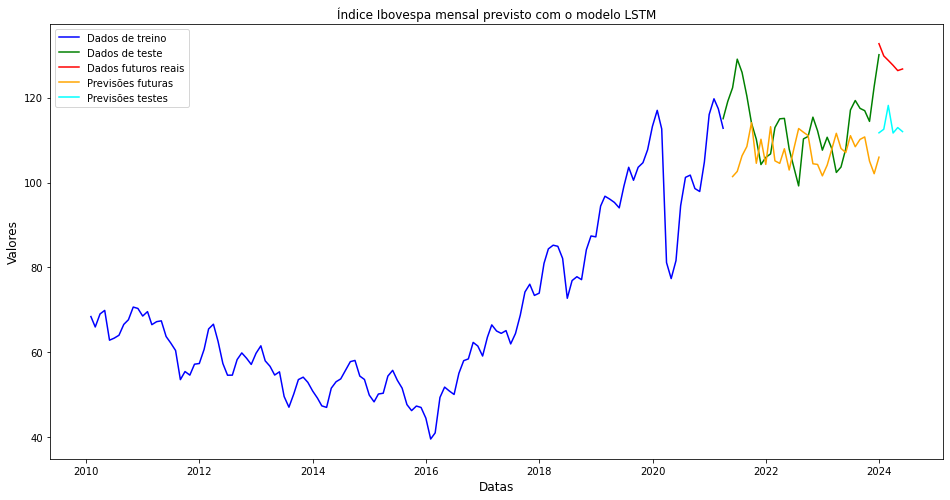

In [34]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_mensal.index, treino_mensal['valor'],color='blue', label='Dados de treino')
plt.plot(teste_mensal.index, teste_mensal['valor'],color='green', label='Dados de teste')
plt.plot(previsao_mensal.index, previsao_mensal['valor'],color='red', label='Dados futuros reais')


# Linha das previsões
plt.plot(teste_mensal[2:].index,best_prediction2,label='Previsões futuras',color = 'orange')
plt.plot(previsao_mensal.index,prediction_val,label='Previsões testes',color = 'cyan')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo LSTM')

plt.legend()
plt.show()

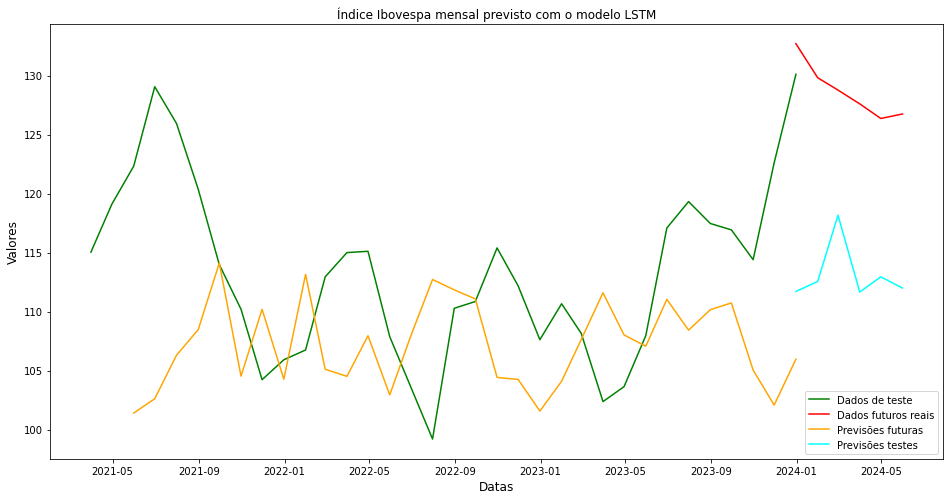

In [35]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino_mensal.index, treino_mensal['valor'],color='blue', label='Dados de treino')
plt.plot(teste_mensal.index, teste_mensal['valor'],color='green', label='Dados de teste')
plt.plot(previsao_mensal.index, previsao_mensal['valor'],color='red', label='Dados futuros reais')


# Linha das previsões
plt.plot(teste_mensal[2:].index,best_prediction2,label='Previsões futuras',color = 'orange')
plt.plot(previsao_mensal.index,prediction_val,label='Previsões testes',color = 'cyan')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo LSTM')

plt.legend()
plt.show()